
Authors: Paula Biderman Mato and Pablo Fuentes Chemes


# Language Modelling
# Lab Assignment: Neural models for word vector representation.

# Introduction
In this notebook, we develop and train a word embedding model designed to predict a central word based on its surrounding context.
The model is trained on a corpus of 30,000 news sentences and aims to learn semantic representations of words.
Additionally, we evaluate the quality of the embeddings through qualitative analysis (cosine similarity, t-SNE visualization) and quantitative analysis (text classification on Reuters dataset).

# 1. Setup and Imports

### Importing Required Libraries

In this section, we import all necessary Python libraries used throughout the notebook:

- **TensorFlow & Keras**: For building and training neural network models.
- **Tokenizer & Sequences**: To preprocess text into numerical sequences.
- **Reuters dataset**: A built-in benchmark dataset for evaluating text classification performance.
- **Scikit-learn tools**: For train/test splitting, cosine similarity, and t-SNE dimensionality reduction.
- **Matplotlib**: For plotting visualizations of embeddings.
- **Other utilities**: Including `os`, `re`, `collections`, and basic data structures like NumPy and Pandas.

These tools form the foundation for all preprocessing, model training, evaluation, and analysis steps in the language modeling pipeline.

In [ ]:
# import necessary libraries

# system and basic utilities
import os, re
import numpy as np
import pandas as pd

# deep learning framework
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, Lambda, Dense, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# dataset and utilities
from tensorflow.keras.datasets import reuters
from tensorflow.keras.utils import to_categorical

# evaluation and training tools
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter


### Loading the Raw Text Corpus

We start by loading the dataset provided for this assignment:  
**`eng_news_2024_30k_sentences.txt`**, which contains 30,000 pre-tokenized English news sentences.

Each line in the file represents a complete sentence. We read the file, remove empty lines, and store all sentences in a list. This corpus will be used to train our context-based word embedding model.

This step is essential to convert the raw text into a format suitable for further tokenization and modeling.

In [ ]:
# path to dataset file
DATA_PATH = 'eng_news_2024_30k_sentences.txt'

In [ ]:
# read raw sentences from the file
with open(DATA_PATH, 'r', encoding='utf-8') as f:
    sentences = [line.strip() for line in f if line.strip()]

print(f"Loaded {len(sentences)} sentences.")
print(sentences[:5])

Loaded 30000 sentences.
['$10-$15 suggested donation goes to Falmouth Land Trust.', '$20,000: Lower Adirondack Pride Festival, June 1 in City Park, Glens Falls.', '$239.4 billion (32nd), comparable to Hungary.', '$35, $75 family of three or more.', '£1,200: Provision of funding for Year 1 & Year 2 children to attend Enchantica Christmas Show / Grove Road Community Primary School.']


# 2. Utility Functions


This section defines several helper functions that are used throughout the notebook for:

- **Embedding visualization** using t-SNE:
  - `visualize_tsne_embeddings()` and `visualize_all_tsne_embeddings()` reduce the dimensionality of selected word vectors to 2D using t-SNE and plot them.
  
- **Text preprocessing**:
  - `expand_contractions()` replaces English contractions (e.g., "don't" → "do not").
  - `preprocess_text()` applies a full preprocessing pipeline, including lowercasing, number and currency normalization, and symbol filtering.

- **Data preparation**:
  - `generate_context_target_pairs()` generates (context, target) training pairs following the CBOW (Continuous Bag of Words) strategy.

- **Model definition**:
  - `build_cbow_model()` builds a CBOW neural architecture: context embeddings are averaged, passed through hidden layers, and a softmax layer predicts the target word.
  - Includes regularization via `Dropout`, `BatchNormalization`, and uses `sparse_categorical_crossentropy` as the loss function.

- **Training utilities**:
  - `get_callbacks()` returns a list of useful training callbacks for early stopping and learning rate reduction.
  - `plot_history()` visualizes training and validation accuracy and loss over epochs.

These utilities promote modularity and reusability, and help keep the main training and evaluation pipeline clean and readable.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

def visualize_tsne_embeddings(words, embeddings, word_index, filename=None):
    """
    Visualizes t-SNE embeddings of selected words.

    Args:
        words (list): List of words to visualize.
        embeddings (numpy.ndarray): Array containing word embeddings.
        word_index (dict): Mapping of words to their indices in the embeddings array.
        filename (str, optional): File to save the visualization. If None, plot is displayed.

    Returns:
        None
    """
    # filter the embeddings for the selected words
    indices = [word_index[word] for word in words]
    selected_embeddings = embeddings[indices]

    # set perplexity for t-SNE, it's recommended to use a value less than the number of selected words
    perplexity = min(5,len(words) - 1)

    # use t-SNE to reduce dimensionality
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=0)
    reduced_embeddings = tsne.fit_transform(selected_embeddings)

    # plotting
    plt.figure(figsize=(10, 10))
    for i, word in enumerate(words):
        plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
        plt.annotate(word, xy=(reduced_embeddings[i, 0], reduced_embeddings[i, 1]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom')

    # save or display the plot
    if filename:
        plt.savefig(filename)
    else:
        plt.show()


def visualize_all_tsne_embeddings(embeddings, word_index, words_to_plot, words_to_label=None, filename=None):
    """
    Visualizes t-SNE embeddings of selected words with optional labeling.

    Args:
        embeddings (numpy.ndarray): Array containing word embeddings.
        word_index (dict): Mapping of words to their indices in the embeddings array.
        words_to_plot (list): List of words to plot.
        words_to_label (list, optional): List of words to label. Defaults to None.
        filename (str, optional): File to save the visualization. If None, plot is displayed.

    Returns:
        None
    """
    # Create a reverse mapping from index to word
    index_word = {index: word for word, index in word_index.items()}

    # Ensure words_to_label is a subset of words_to_plot
    if words_to_label is None:
        words_to_label = words_to_plot
    words_to_label = set(words_to_label).intersection(words_to_plot)

    # Filter the embeddings for the words to plot
    indices_to_plot = [word_index[word] for word in words_to_plot if word in word_index]
    selected_embeddings = embeddings[indices_to_plot]

    # Set perplexity for t-SNE, it's recommended to use a value less than the number of selected words
    perplexity = min(5,len(words_to_plot) - 1)

    # Use t-SNE to reduce dimensionality
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=0)
    reduced_embeddings = tsne.fit_transform(selected_embeddings)

    # Plotting
    plt.figure(figsize=(12, 12))
    for i, index in enumerate(indices_to_plot):
        plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], alpha=0.5)
        if index_word[index] in words_to_label:  # Annotate only selected words
            plt.annotate(index_word[index],
                         xy=(reduced_embeddings[i, 0], reduced_embeddings[i, 1]),
                         xytext=(5, 2),
                         textcoords='offset points',
                         ha='right',
                         va='bottom')


CONTRACTIONS = {
    "he's": "he is",
    "she's": "she is",
    "it's": "it is",
    "that's": "that is",
    "what's": "what is",
    "who's": "who is",
    "i'm": "i am",
    "you're": "you are",
    "they're": "they are",
    "we're": "we are",
    "can't": "can not",
    "cannot": "can not",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "here's": "here is",
    "how's": "how is",
    "i'd": "i would",
    "i'll": "i will",
    "i've": "i have",
    "isn't": "is not",
}

def expand_contractions(text):
    # Normalizar apostrofe “curly” a straight
    text = text.replace("’", "'")
    # Expandir cada contracción del diccionario (word boundaries)
    for contr, full in CONTRACTIONS.items():
        pattern = r"\b" + re.escape(contr) + r"\b"
        text = re.sub(pattern, full, text, flags=re.IGNORECASE)
    return text


def preprocess_text(text):
    # a) minúsculas
    text = text.lower()
    # b) expandir contracciones
    text = expand_contractions(text)
    # c) eliminar posesivos 's (lo que quede de view's, king's, etc.)
    text = re.sub(r"'s\b", "", text)
    # 1) Rangos numéricos con pm/am
    text = re.sub(r'\b(\d+)\s*p\.?m\.?', '<num> pm', text)
    text = re.sub(r'\b(\d+)\s*a\.?m\.?', '<num> am', text)
    # 2) Números, decimales, miles y ordinales
    text = re.sub(r'[$£€]?[\d]+(?:[.,]\d+)*(?:st|nd|rd|th)?', '<num>', text)
    # 4) Elimina símbolos de moneda y todo excepto letras, espacios y <>
    text = re.sub(r'[$£€]', ' ', text)
    text = re.sub(r'[^a-zñáéíóúü<> ]+', ' ', text)
    # 3) Unifica múltiples <num>
    text = re.sub(r'(?:<num>\s+){2,}', '<num> ', text)
    # 5) Colapsa espacios
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def generate_context_target_pairs(sequences, window):
    """
    From integer sequences generate (context, target) pairs for CBOW.
    """
    inputs, targets = [], []
    maxlen = window * 2
    for seq in sequences:
        for i in range(window, len(seq) - window):
            context = seq[i-window:i] + seq[i+1:i+1+window]
            target = seq[i]
            if len(context) == maxlen:
                inputs.append(context)
                targets.append(seq[i])
    return np.array(inputs), np.array(targets)


def build_cbow_model(vocab_size, window, embedding_dim):
    """
    Builds a CBOW model: average context embeddings -> hidden layers -> softmax
    """
    maxlen = window * 2
    inp = Input(shape=(maxlen,), name='context_inputs')
    emb = Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=maxlen,
                    name='embedding')(inp)
    avg = Lambda(lambda x: tf.reduce_mean(x, axis=1), name='average_context')(emb)
    x = Dense(256, activation='relu')(avg)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    out = Dense(vocab_size, activation='softmax', name='target_output')(x)
    model = Model(inputs=inp, outputs=out, name=f'cbow_w{window}_d{embedding_dim}')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def get_callbacks():
    """EarlyStopping, ReduceLROnPlateau, ModelCheckpoint"""
    es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=0)
    rl = ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.5, min_lr=1e-6, verbose=0)
    return [es, rl]


def plot_history(history, figsize=(12, 5)):
    """
    Plot training & validation accuracy and loss from a keras History object.

    Args:
        history: keras.callbacks.History returned by model.fit(...)
        figsize: tuple con el tamaño de la figura (ancho, alto)
    """
    # Extrae los valores
    acc       = history.history.get('accuracy', [])
    val_acc   = history.history.get('val_accuracy', [])
    loss      = history.history.get('loss', [])
    val_loss  = history.history.get('val_loss', [])
    epochs    = range(1, len(acc) + 1)

    plt.figure(figsize=figsize)

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc,      label='Training Acc')
    plt.plot(epochs, val_acc,  label='Validation Acc')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss,     label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


# 3. Preprocessing the Sentences

In this step, we apply the preprocessing pipeline to clean all input sentences from the corpus.

The `preprocess_text()` function previously defined:
- Converts all text to lowercase
- Expands English contractions (e.g., "she's" → "she is")
- Normalizes numbers and currency symbols (replacing them with `<num>`)
- Removes unwanted characters and reduces whitespace

This step ensures that the text is normalized and noise-free before tokenization.

After cleaning, we print a few examples to compare the raw and cleaned versions of the sentences.

In [ ]:
# apply preprocessing to all sentences in the dataset
clean_sentences = [preprocess_text(s) for s in sentences]

# quick check to compare original and preprocessed sentences
print(sentences[:5])
print(clean_sentences[:5])

['$10-$15 suggested donation goes to Falmouth Land Trust.', '$20,000: Lower Adirondack Pride Festival, June 1 in City Park, Glens Falls.', '$239.4 billion (32nd), comparable to Hungary.', '$35, $75 family of three or more.', '£1,200: Provision of funding for Year 1 & Year 2 children to attend Enchantica Christmas Show / Grove Road Community Primary School.']
['<num> suggested donation goes to falmouth land trust', '<num> lower adirondack pride festival june <num> in city park glens falls', '<num> billion <num> comparable to hungary', '<num> family of three or more', '<num> provision of funding for year <num> year <num> children to attend enchantica christmas show grove road community primary school']


### Tokenization and Vocabulary Size Selection

In this section, we convert each preprocessed sentence into a sequence of word indices using Keras' `Tokenizer`.

Key steps:
- We initialize the tokenizer with an out-of-vocabulary (OOV) token to handle rare words.
- We fit the tokenizer on the cleaned text to compute word frequencies.
- To balance vocabulary size and generalization, we compute how many of the most frequent words are needed to cover **90% of the total word occurrences** in the corpus.
- We update `vocab_size` accordingly.
- Finally, we convert each sentence into a sequence of word indices based on the tokenizer.

This step transforms the text corpus into a numerical format suitable for training neural networks.

In [ ]:
vocab_size = 11260 #adjusted based on the following analysis

# Tokenize the cleaned sentences
# Initialize a Keras Tokenizer and fit it on the loaded sentences. Each word will be assigned a unique integer index.
# The OOV token is used to handle rare or unseen words
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(clean_sentences)
counts = tokenizer.word_counts

# Calculate cumulative token coverage to determine optimal vocabulary size
total_tokens = sum(counts.values())
cum = 0
threshold = 0.90  # we want to cover 90% of the token occurrences in the corpus
for i, (_, cnt) in enumerate(counts.items(), start=1):
    cum += cnt
    if cum/total_tokens >= threshold:
        vocab_size = i  # keep the top-i words that cover 90%
        break

print(f"To cover 90% of the corpus, you need vocab_size of aprox. {vocab_size}")

sequences = tokenizer.texts_to_sequences(clean_sentences)
word_index = tokenizer.word_index
print(f"Vocabulary size: {len(word_index)}")

Para cubrir el 90% del corpus te basta con vocab_size ≃ 11260
Vocabulary size: 39153


# 4. Experiments Loop: Training Multiple CBOW Models

In this section, we systematically train multiple continuous bag-of-words (CBOW) embedding models by varying two key hyperparameters:

1. **Context window size** (`context_windows`): number of words on each side of the target (e.g., 2 or 5).
2. **Embedding dimension** (`embedding_dims`): size of the vector for each word (50, 100, or 200).

For each `(window, dim)` combination:

- Generate (context, target) pairs using `generate_context_target_pairs(sequences, window)`.
- Split the data into training (90%) and validation (10%) sets.
- Build the model with `build_cbow_model(vocab_size, window, dim)`.
- Train for up to 100 epochs with early stopping and learning-rate reduction callbacks.
- Plot training/validation accuracy and loss via `plot_history`.
- Extract the learned embeddings from the embedding layer and save them to disk as `embeddings_w{window}_d{dim}.npy` for future evaluation.
- Store each model, its history, and embedding matrix in the `results` dictionary for downstream analysis.

This systematic loop allows for a fair comparison across different embedding configurations.


In [ ]:
# define the grid of hyperparameters
context_windows = [2, 5]           # number of words to each side of the target
embedding_dims  = [50, 100, 200]   # dimensionality of word embeddings

Window=2: 481814 samples
Training CBOW: window=2, dim=50
Epoch 1/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.0852 - loss: 7.2171 - val_accuracy: 0.1256 - val_loss: 6.2299 - learning_rate: 5.0000e-04
Epoch 2/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.1286 - loss: 6.2386 - val_accuracy: 0.1452 - val_loss: 6.0601 - learning_rate: 5.0000e-04
Epoch 3/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.1459 - loss: 6.0498 - val_accuracy: 0.1534 - val_loss: 5.9687 - learning_rate: 5.0000e-04
Epoch 4/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.1563 - loss: 5.9342 - val_accuracy: 0.1616 - val_loss: 5.9089 - learning_rate: 5.0000e-04
Epoch 5/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.1632 - loss: 5.8505 - val_accuracy: 0.1646 - val_loss: 5.8684 - learning_rate: 5.0000e-04
Epoch 6/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.1693 - loss: 5.7875 - val_accuracy: 0.1674 - val_loss: 5.8354 - learning_

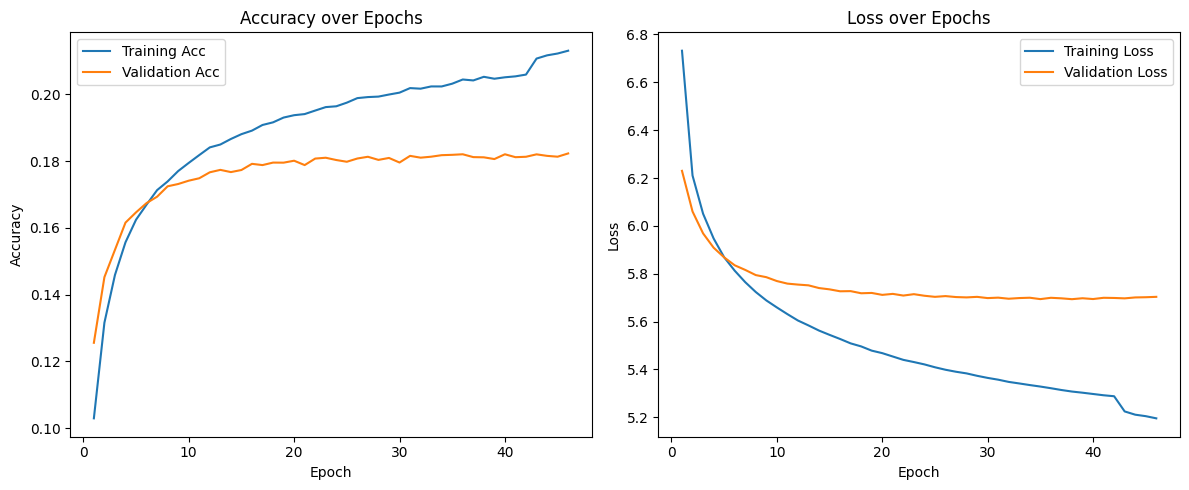

Saved embeddings_w2_d50.npy with shape (11260, 50)
Training CBOW: window=2, dim=100
Epoch 1/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.0864 - loss: 7.2119 - val_accuracy: 0.1299 - val_loss: 6.2232 - learning_rate: 5.0000e-04
Epoch 2/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.1301 - loss: 6.2249 - val_accuracy: 0.1484 - val_loss: 6.0442 - learning_rate: 5.0000e-04
Epoch 3/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.1479 - loss: 6.0283 - val_accuracy: 0.1578 - val_loss: 5.9511 - learning_rate: 5.0000e-04
Epoch 4/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.1583 - loss: 5.9129 - val_accuracy: 0.1631 - val_loss: 5.8908 - learning_rate: 5.0000e-04
Epoch 5/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.1667 - loss: 5.8239 - val_accuracy: 0.1656 - val_loss: 5.8513 - learning_rate: 5.0000e-04
Epoch 6/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.1713 - loss: 5.7553 - val_accuracy: 0.1701 - v

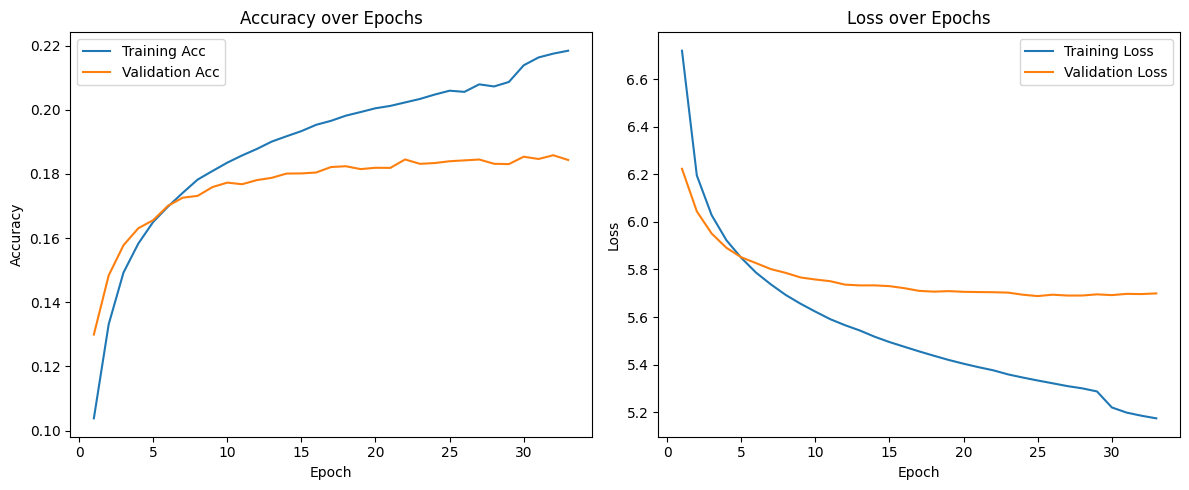

Saved embeddings_w2_d100.npy with shape (11260, 100)
Training CBOW: window=2, dim=200
Epoch 1/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.0863 - loss: 7.1982 - val_accuracy: 0.1310 - val_loss: 6.2100 - learning_rate: 5.0000e-04
Epoch 2/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.1312 - loss: 6.2118 - val_accuracy: 0.1475 - val_loss: 6.0317 - learning_rate: 5.0000e-04
Epoch 3/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.1483 - loss: 6.0133 - val_accuracy: 0.1580 - val_loss: 5.9388 - learning_rate: 5.0000e-04
Epoch 4/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.1601 - loss: 5.8931 - val_accuracy: 0.1655 - val_loss: 5.8772 - learning_rate: 5.0000e-04
Epoch 5/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.1681 - loss: 5.8136 - val_accuracy: 0.1694 - val_loss: 5.8425 - learning_rate: 5.0000e-04
Epoch 6/100
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - accuracy: 0.1739 - loss: 5.7559 - val_accuracy: 0.1723 -

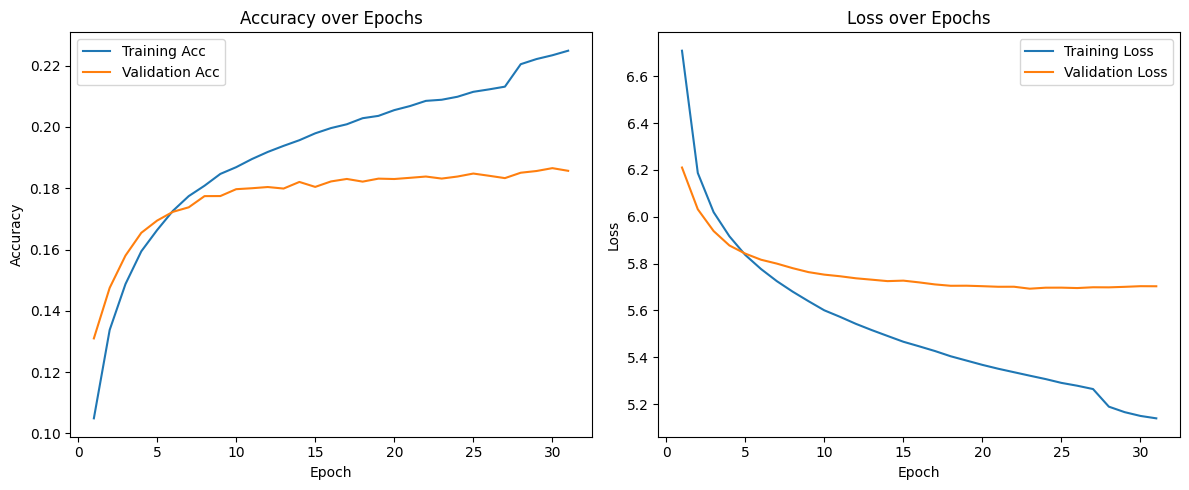

Saved embeddings_w2_d200.npy with shape (11260, 200)
Window=5: 311919 samples
Training CBOW: window=5, dim=50
Epoch 1/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.0615 - loss: 7.5540 - val_accuracy: 0.0898 - val_loss: 6.5198 - learning_rate: 5.0000e-04
Epoch 2/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.0907 - loss: 6.5164 - val_accuracy: 0.0976 - val_loss: 6.4288 - learning_rate: 5.0000e-04
Epoch 3/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.0985 - loss: 6.3711 - val_accuracy: 0.1034 - val_loss: 6.3584 - learning_rate: 5.0000e-04
Epoch 4/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.1098 - loss: 6.2599 - val_accuracy: 0.1111 - val_loss: 6.3110 - learning_rate: 5.0000e-04
Epoch 5/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.1173 - loss: 6.1735 - val_accuracy: 0.1155 - val_loss: 6.2751 - learning_rate: 5.0000e-04
Epoch 6/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.1257 - loss: 6.0989 

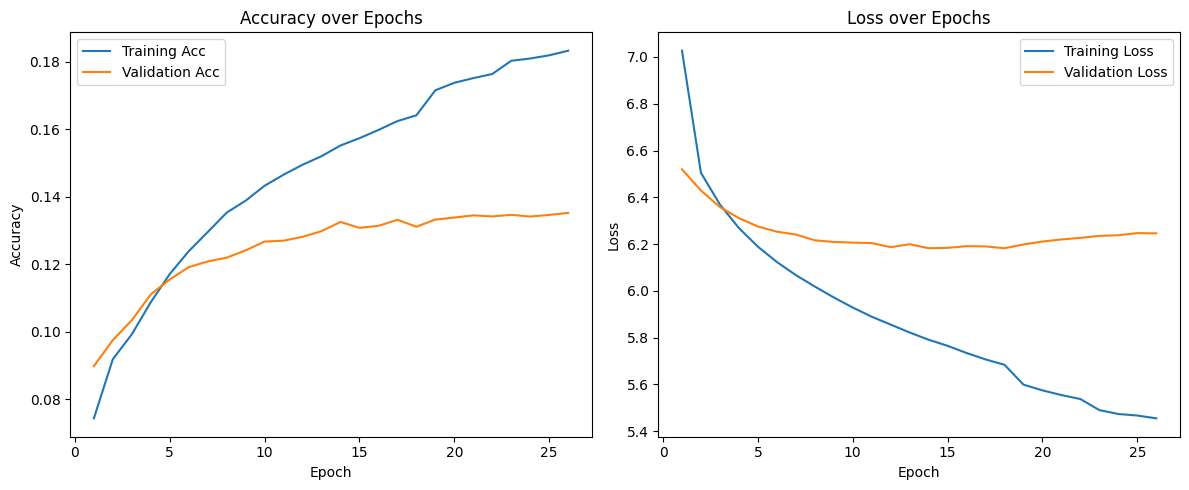

Saved embeddings_w5_d50.npy with shape (11260, 50)
Training CBOW: window=5, dim=100
Epoch 1/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.0609 - loss: 7.5587 - val_accuracy: 0.0916 - val_loss: 6.5155 - learning_rate: 5.0000e-04
Epoch 2/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.0905 - loss: 6.5222 - val_accuracy: 0.0981 - val_loss: 6.4154 - learning_rate: 5.0000e-04
Epoch 3/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.1018 - loss: 6.3651 - val_accuracy: 0.1068 - val_loss: 6.3499 - learning_rate: 5.0000e-04
Epoch 4/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.1121 - loss: 6.2374 - val_accuracy: 0.1120 - val_loss: 6.2950 - learning_rate: 5.0000e-04
Epoch 5/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.1234 - loss: 6.1390 - val_accuracy: 0.1180 - val_loss: 6.2562 - learning_rate: 5.0000e-04
Epoch 6/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.1293 - loss: 6.0689 - val_accuracy: 0.1219 - v

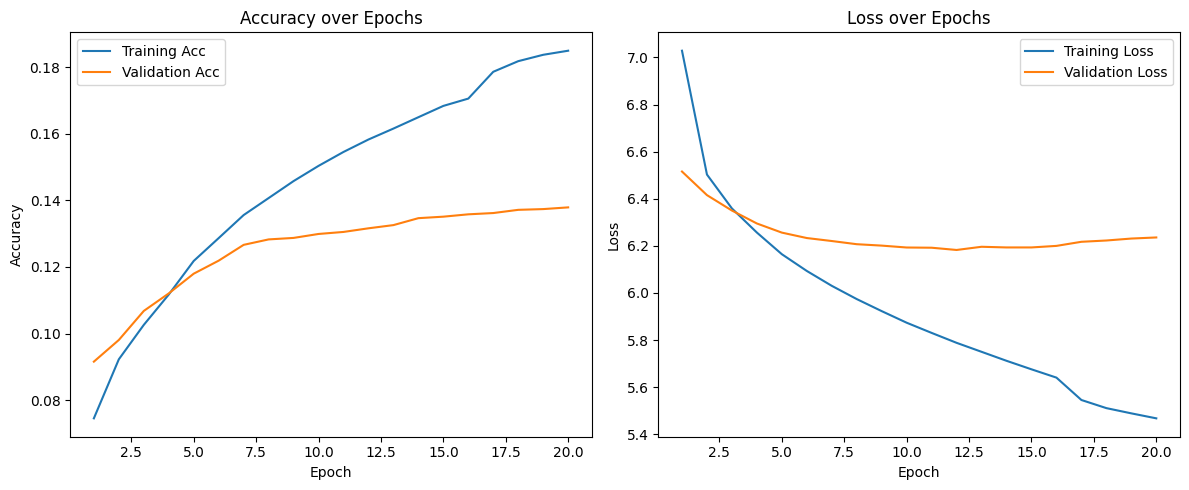

Saved embeddings_w5_d100.npy with shape (11260, 100)
Training CBOW: window=5, dim=200
Epoch 1/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.0613 - loss: 7.5571 - val_accuracy: 0.0915 - val_loss: 6.5105 - learning_rate: 5.0000e-04
Epoch 2/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.0933 - loss: 6.4956 - val_accuracy: 0.1016 - val_loss: 6.4114 - learning_rate: 5.0000e-04
Epoch 3/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.1054 - loss: 6.3396 - val_accuracy: 0.1113 - val_loss: 6.3281 - learning_rate: 5.0000e-04
Epoch 4/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.1165 - loss: 6.2222 - val_accuracy: 0.1170 - val_loss: 6.2695 - learning_rate: 5.0000e-04
Epoch 5/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.1262 - loss: 6.1151 - val_accuracy: 0.1225 - val_loss: 6.2356 - learning_rate: 5.0000e-04
Epoch 6/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.1337 - loss: 6.0377 - val_accuracy: 0.1252 -

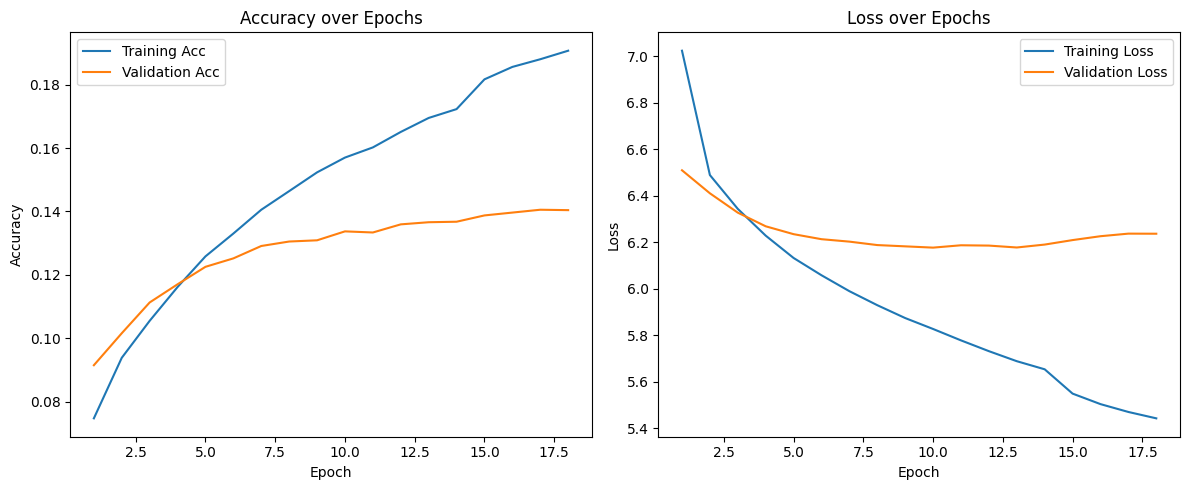

Saved embeddings_w5_d200.npy with shape (11260, 200)


In [ ]:
results = {} # dictionary to store all models and results

# iterate over context window sizes
for window in context_windows:
    maxlen = window * 2

    # generate context–target training pairs
    X, y = generate_context_target_pairs(sequences, window)
    print(f"Window={window}: {X.shape[0]} samples")

    # split into training and validation sets (90% / 10%)
    x_tr, x_val, y_tr, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

    # iterate over embedding dimensions
    for dim in embedding_dims:
        print(f"Training CBOW: window={window}, dim={dim}")

        # build CBOW model with the specified hyperparameters
        model = build_cbow_model(vocab_size, window, dim)

        # train the model with callbacks
        history = model.fit(
            x_tr, y_tr,
            validation_data=(x_val, y_val),
            epochs=100,
            batch_size=64,
            callbacks=get_callbacks(),
            verbose=1
        )

        # plot training and validation performance
        plot_history(history)

        # extract and save the trained embedding matrix
        emb_matrix = model.get_layer('embedding').get_weights()[0]
        np.save(f'embeddings_w{window}_d{dim}.npy', emb_matrix)
        print(f"Saved embeddings_w{window}_d{dim}.npy with shape {emb_matrix.shape}")

        # store model, history and embeddings in results dictionary
        results[(window, dim)] = {
            'model': model,
            'history': history,
            'embeddings': emb_matrix
        }

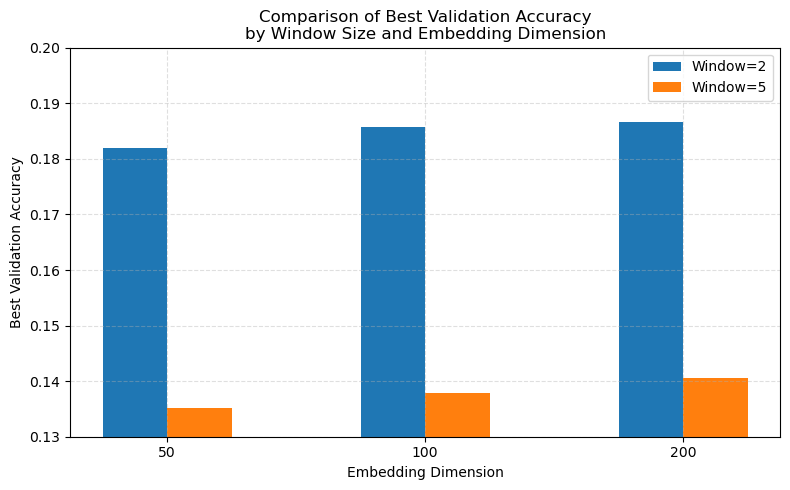

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# mejor val_accuracy para cada combinación 
configs = {
    (2, 50): 0.1820,
    (2, 100): 0.1858,
    (2, 200): 0.1866,
    (5, 50): 0.1352,
    (5, 100): 0.1379,
    (5, 200): 0.1405,
}

# Ordenamos por ventana y dimensión
windows = sorted(set(k[0] for k in configs.keys()))
dims = sorted(set(k[1] for k in configs.keys()))

# Creamos matriz de accuracies para graficar
accuracy_matrix = np.array([[configs[(w, d)] for d in dims] for w in windows])

# Gráfico de barras agrupadas
bar_width = 0.25
x = np.arange(len(dims))

fig, ax = plt.subplots(figsize=(8, 5))
for i, w in enumerate(windows):
    ax.bar(x + i * bar_width, accuracy_matrix[i], width=bar_width, label=f'Window={w}')

# Ejes y etiquetas
ax.set_xlabel('Embedding Dimension')
ax.set_ylabel('Best Validation Accuracy')
ax.set_title('Comparison of Best Validation Accuracy\nby Window Size and Embedding Dimension')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(dims)
ax.set_ylim(0.13, 0.20)
ax.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


This validation accuracy results indicate that using a smaller context window (window=2) consistently leads to better performance compared to a larger window (window=5). The highest validation accuracy is achieved with window=2 and dim=200 (≈ 0.1866), although the improvement from dim=100 (0.1858) is minimal, suggesting diminishing returns when increasing the embedding size. For window=5, validation accuracy increases with higher dimensions, but remains lower overall. These findings suggest that capturing closer context is more effective for this dataset, and that while richer embeddings help, their benefit plateaus beyond a certain point.

# 5. Embedding Analysis: Cosine Similarity and t-SNE Visualization

In this section, we perform a qualitative evaluation of each pretrained embedding matrix stored in the `results` dictionary:

1. **Load target words**  
   We read a list of words of interest from `target_words.txt`.

2. **Iterate over each `(window, dim)` combination**  
   For each model configuration, retrieve its embedding matrix.

3. **Cosine similarity**  
   For the first 10 target words, compute their cosine similarity against the entire vocabulary. We then display each word’s top 10 nearest neighbors (highest similarity scores).

4. **t-SNE visualization**  
   Select up to 100 of the target words, project their high-dimensional vectors down to 2D via t-SNE, and plot the points—labeling each with its word. This allows us to visually inspect clustering and semantic relationships.


In [ ]:
# load list of target words to evaluate (one word per line)
with open('target_words.txt') as f:
    target_words = [w.strip() for w in f]

# loop over each trained configuration of embeddings
for (window, dim), info in results.items():
    emb = info['embeddings']
    print(f"\n=== Analysis for window={window}, dim={dim} ===")

    # cosine similarity: show 10 most similar words for the first 10 target words
    print("\nTop-10 most similar words per target:")
    for word in target_words[:10]:
        idx = tokenizer.word_index.get(word)
        # skip words not in vocabulary or OOV
        if idx is None or idx >= vocab_size:
            continue
        # compute cosine similarity between this word and all other embeddings
        sims = cosine_similarity([emb[idx]], emb)[0]
        top_idx = sims.argsort()[-11:-1][::-1] #  top 10 excluding the word itself
        similar = [tokenizer.index_word[i] for i in top_idx]
        print(f"{word:12s} → {similar}")


=== Analysis for window=2, dim=50 ===

Top-10 most similar words per target:
everyone     → ['anyone', 'god', 'me', 'it', 'pensioners', 'everything', 'them', 'someone', 'donors', 'suitable']
music        → ['favorites', 'abroad', 'queer', 'computers', 'authentic', 'hyatt', 'candy', 'pride', 'mohammad', 'kenny']
running      → ['pressed', 'touring', 'lined', 'stationed', 'hawaii', 'located', 'carrying', 'sophomore', 'negotiating', 'shut']
worse        → ['more', 'faster', 'less', 'better', 'rather', 'risky', 'bigger', 'erased', 'slower', 'little']
friday       → ['wednesday', 'thursday', 'monday', 'tuesday', 'sunday', 'saturday', 'july', 'nhtsa', 'sept', 'posting']
september    → ['february', 'october', 'july', 'april', 'june', 'december', 'august', 'sept', 'oct', 'march']
someone      → ['something', 'vitamin', 'allah', 'everyone', 'anxious', 'them', 'descent', 'god', 'others', 'barkley']
getting      → ['gaining', 'woke', 'tasked', 'rolled', 'haunting', 'crashing', 'legally', 'walkin

### Qualitative Evaluation via t-SNE Visualization

To visually inspect the quality of the learned embeddings, we apply **t-SNE** to project high-dimensional word vectors into a 2D space.

We compare:

1. **Before Training**:
   - We extract the random (untrained) embedding matrix of a CBOW model.
   - We visualize a list of target words to see their initial random placement.

2. **After Training**:
   - For each `(context_window, embedding_dim)` configuration, we use the trained embedding matrix.
   - We apply t-SNE on the same list of target words to inspect whether semantic clusters or structures emerge.

This qualitative visualization helps understand whether the model has learned meaningful geometric structures in the embedding space.

t-SNE of target words **before** training (random init):


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


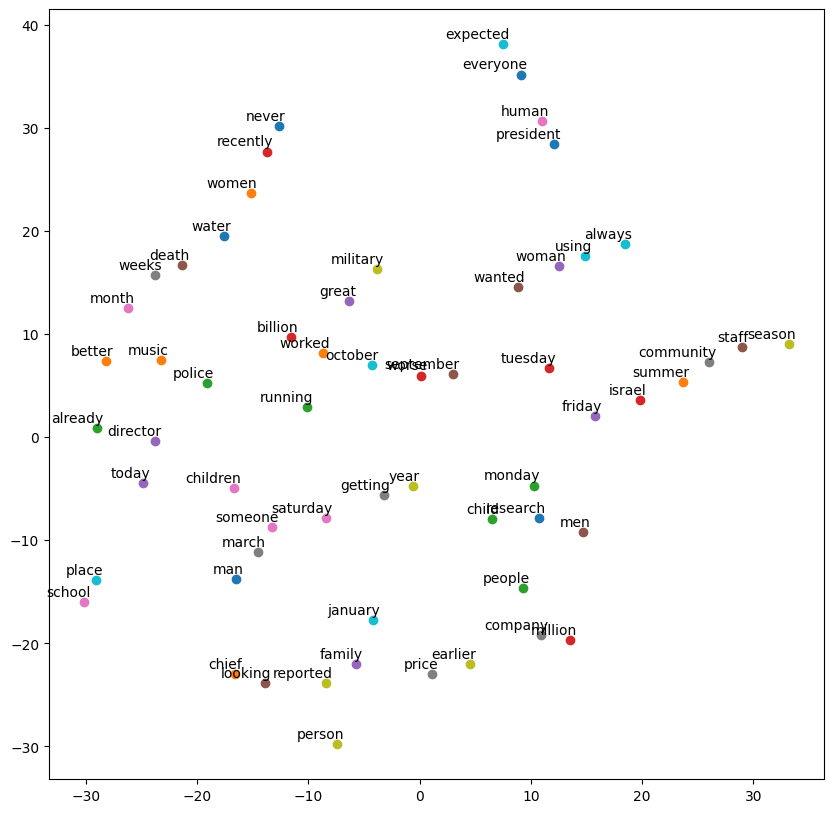

t-SNE of target words **after** training (window=2, dim=50):


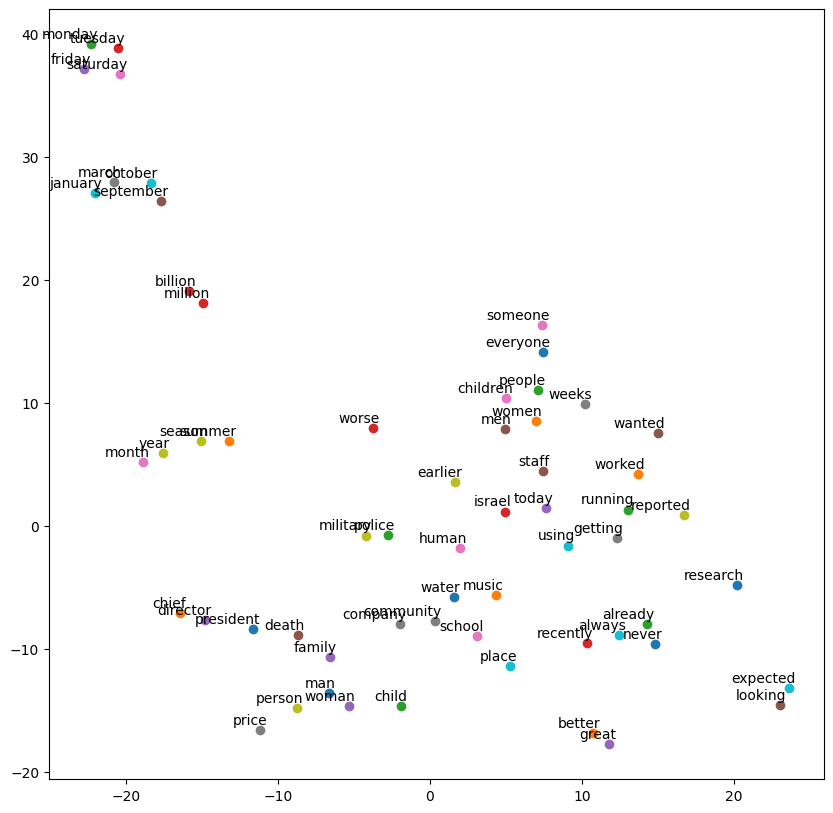

t-SNE of target words **after** training (window=2, dim=100):


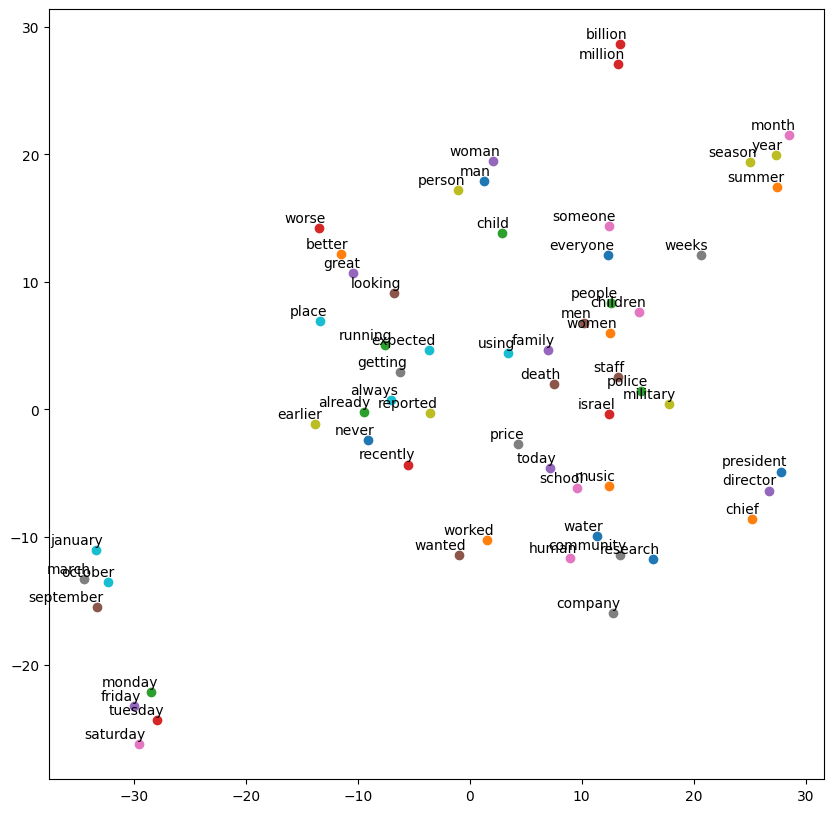

t-SNE of target words **after** training (window=2, dim=200):


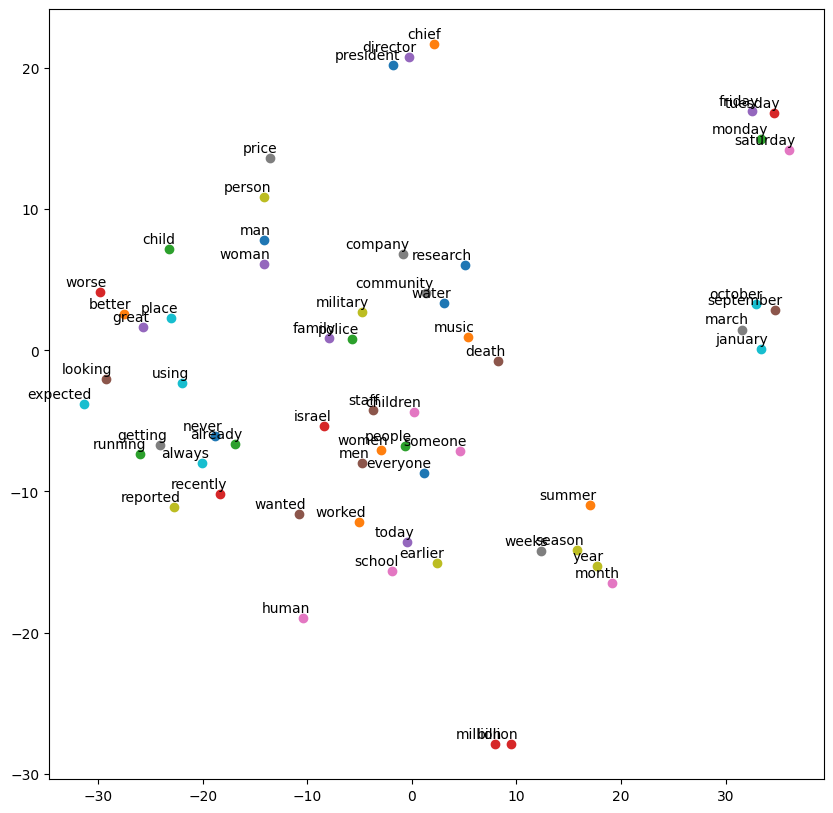

t-SNE of target words **after** training (window=5, dim=50):


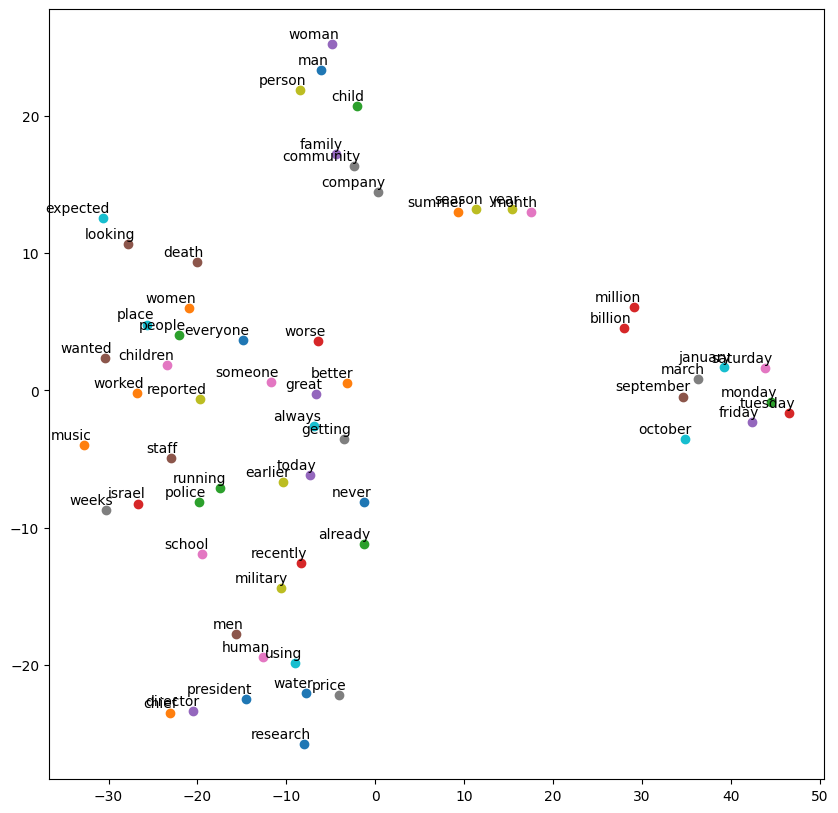

t-SNE of target words **after** training (window=5, dim=100):


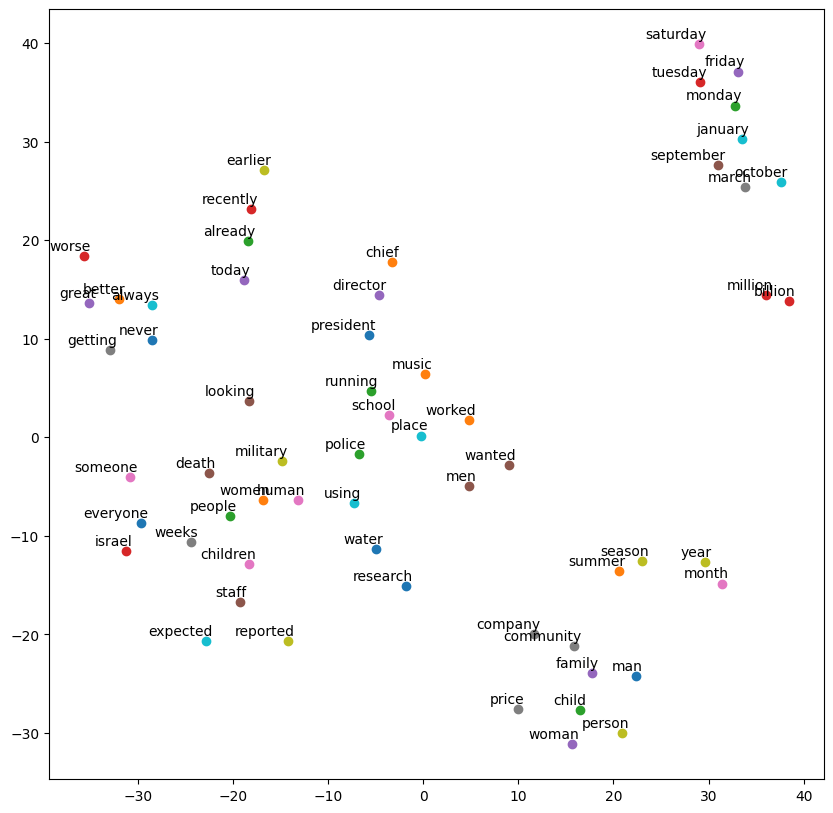

t-SNE of target words **after** training (window=5, dim=200):


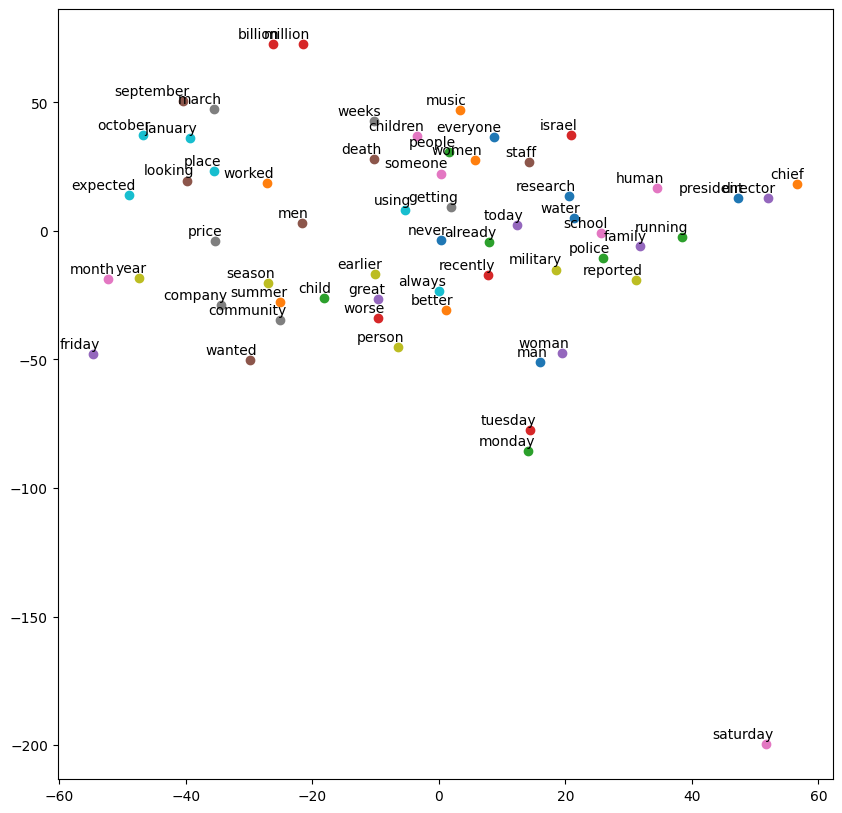

In [ ]:
# (i) visualize embeddings before training
print("t-SNE of target words **before** training (random init):")

# build an untrained CBOW model to get its initial random embedding matrix
random_model = build_cbow_model(vocab_size, window=context_windows[0], embedding_dim=embedding_dims[0])
initial_embeddings = random_model.get_layer('embedding').get_weights()[0]

# project random embeddings of target words into 2D using t-SNE
visualize_tsne_embeddings(
    words=target_words,
    embeddings=initial_embeddings,
    word_index=tokenizer.word_index
    )

# (ii) visualize trained embeddings for each configuration
for (window, dim), info in results.items():
    print(f"t-SNE of target words **after** training (window={window}, dim={dim}):")
    trained_embeddings = info['embeddings']

    # using the same target_words list, visualize the learned embeddings while projecting trained embeddings of target words into 2D
    visualize_tsne_embeddings(
        words=target_words,
        embeddings=trained_embeddings,
        word_index=tokenizer.word_index
    )


# 6. Quantitative Analysis: Classifier Comparison Across Embedding Dimensions

In this section, we evaluate how using our pretrained CBOW embeddings impacts a downstream text classification task on the Reuters dataset. The workflow is:

1. **Load & preprocess Reuters**  
   - Restrict the vocabulary to `VOCAB_SIZE`, pad all sequences to length `MAXLEN_CLS`, and one-hot encode the labels into `NUM_CLASSES` categories.

2. **Build a classifier factory**  
   - Define `build_classification_model(embeddings_matrix=None, emb_dim=100)` which returns a Conv1D-based classifier.  
   - If `embeddings_matrix` is provided, it is loaded (frozen) into the embedding layer; otherwise, a trainable embedding of size `emb_dim` is used.

3. **Compare random vs. pretrained embeddings**  
   For each `(window, dim)` key in `results` (i.e. each CBOW configuration):  
   - **Baseline**: train a classifier with randomly initialized embeddings of dimension `dim`.  
   - **Pretrained**: train the same classifier architecture, but initialize the embedding layer with the pretrained `emb_matrix` and freeze it.  
   - Evaluate both models on the test set, printing their test accuracies.

4. **Store and visualize**  
   - Save each run’s training history and test accuracy into `comparison_results`.  
   - Plot side-by-side validation accuracy and validation loss curves (dashed = random, solid = pretrained) for direct comparison of convergence behavior and final performance.

This allows us to quantify and visualize the benefit (or drawback) of initializing with our learned embeddings versus learning from scratch for each embedding dimension and context window size.


In [ ]:
# 1. load and preprocess Reuters dataset
VOCAB_SIZE = vocab_size  # same as used for embeddings training
MAXLEN_CLS = 256 # fixed length for input sequences

# load data and limit to VOCAB_SIZE most frequent words
(x_train_r, y_train_r), (x_test_r, y_test_r) = reuters.load_data(num_words=VOCAB_SIZE)
# pad sequences for CNN input
x_train_r = pad_sequences(x_train_r, maxlen=MAXLEN_CLS)
x_test_r  = pad_sequences(x_test_r, maxlen=MAXLEN_CLS)

# one-hot encode labels 
y_train_r = to_categorical(y_train_r)
y_test_r  = to_categorical(y_test_r)
NUM_CLASSES = y_train_r.shape[1]

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step



=== window=2, emb_dim=50 ===
Training baseline (random embeddings)...
Training with pretrained embeddings...
Baseline acc: 0.6839 — Pretrained acc: 0.6220


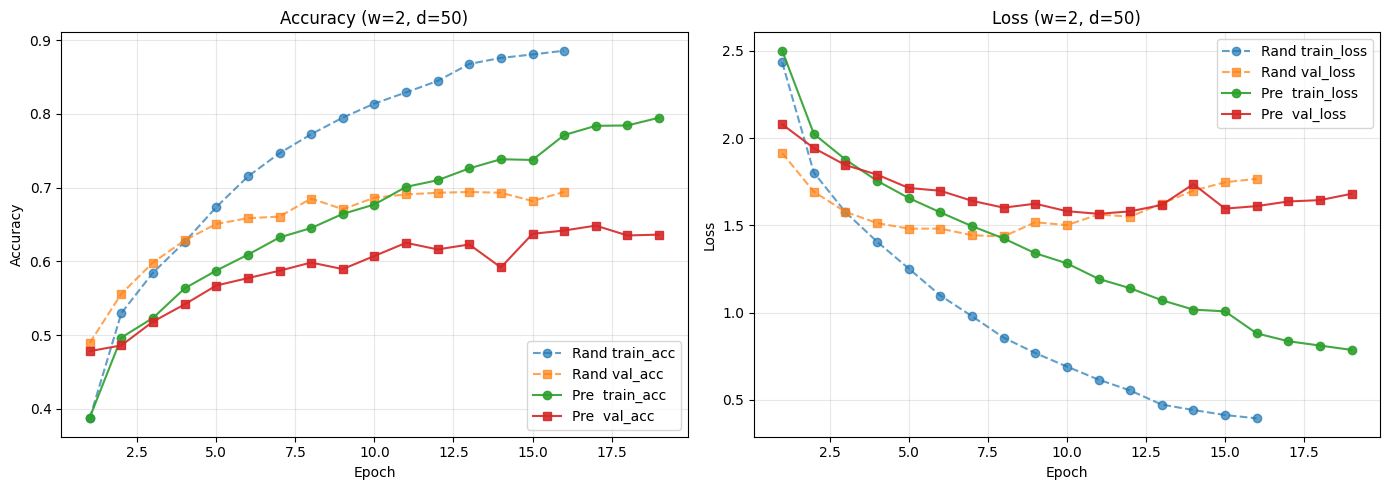


=== window=2, emb_dim=100 ===
Training baseline (random embeddings)...
Training with pretrained embeddings...
Baseline acc: 0.6598 — Pretrained acc: 0.6572


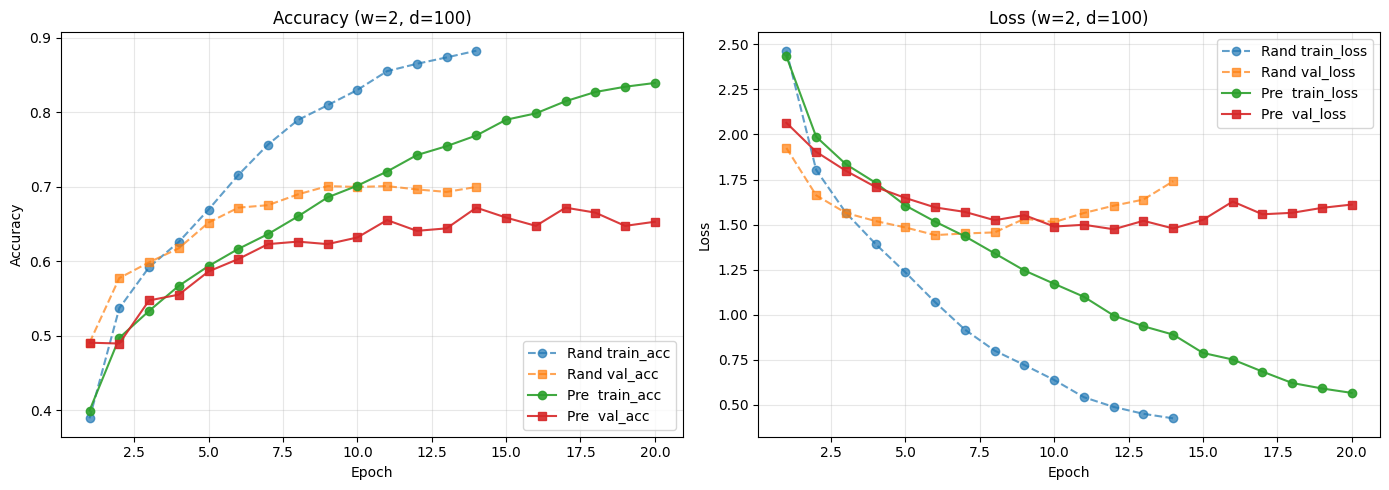


=== window=2, emb_dim=200 ===
Training baseline (random embeddings)...
Training with pretrained embeddings...
Baseline acc: 0.7093 — Pretrained acc: 0.6714


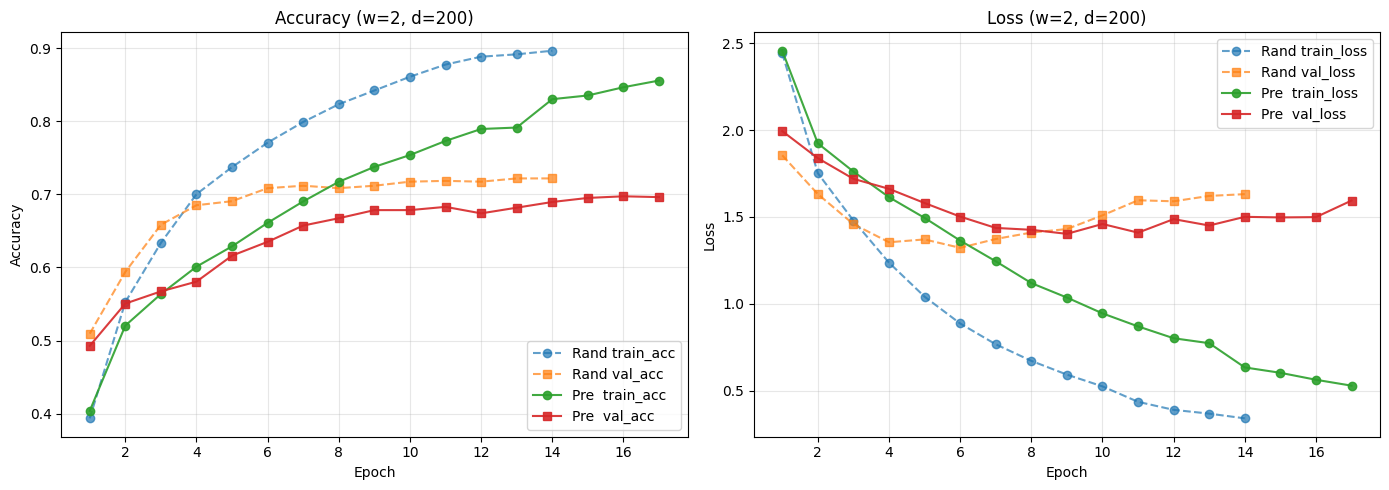


=== window=5, emb_dim=50 ===
Training baseline (random embeddings)...
Training with pretrained embeddings...
Baseline acc: 0.6785 — Pretrained acc: 0.6180


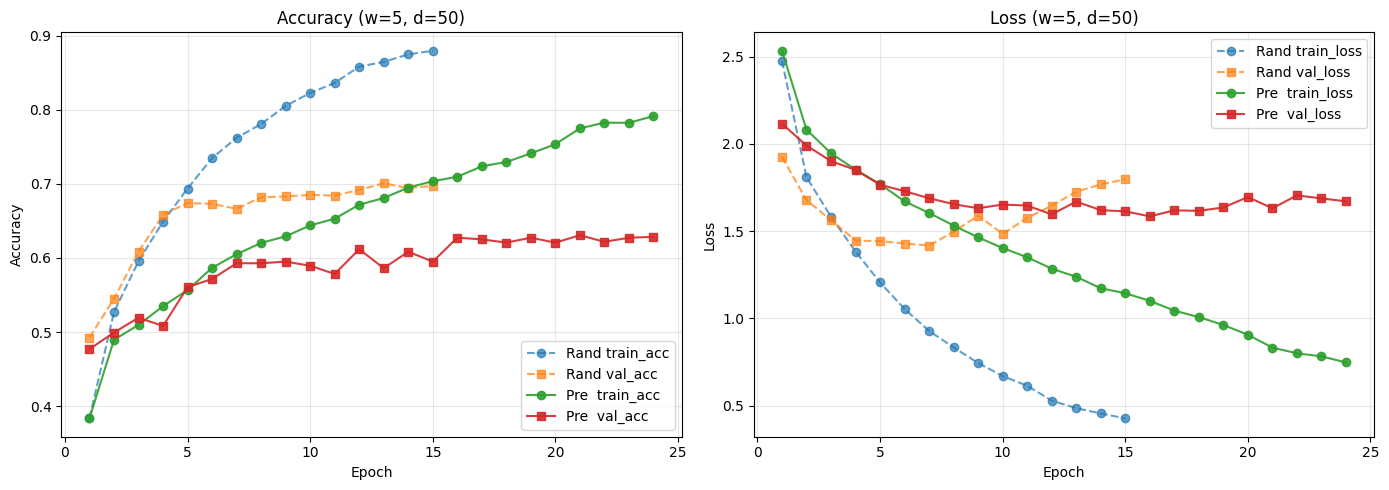


=== window=5, emb_dim=100 ===
Training baseline (random embeddings)...
Training with pretrained embeddings...
Baseline acc: 0.6670 — Pretrained acc: 0.6549


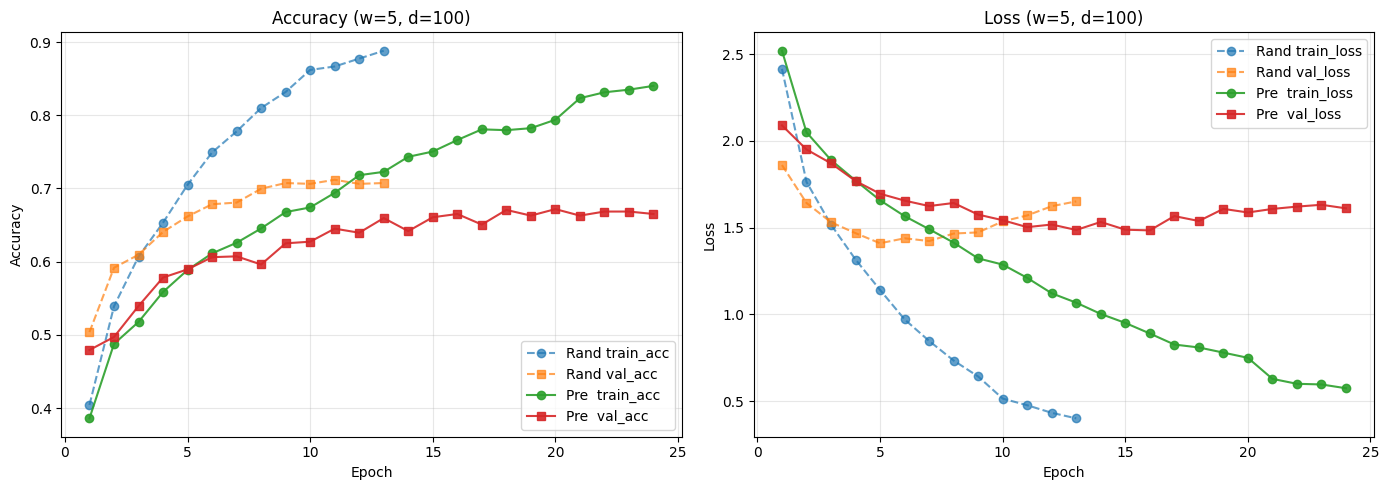


=== window=5, emb_dim=200 ===
Training baseline (random embeddings)...
Training with pretrained embeddings...
Baseline acc: 0.6946 — Pretrained acc: 0.6585


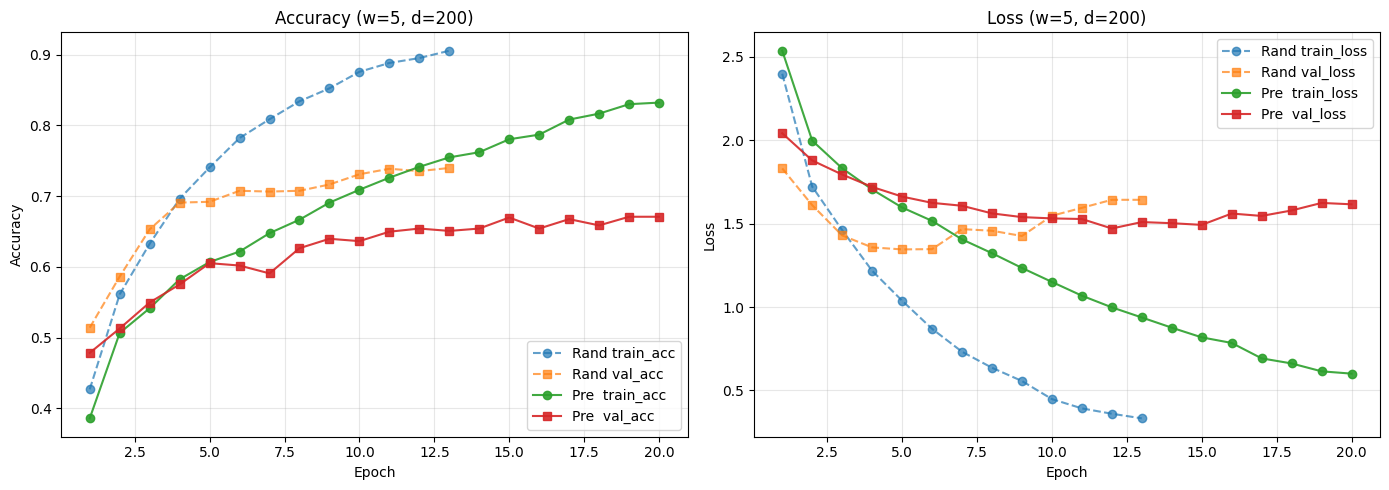

In [ ]:
# 2. define CNN classifier builder accepting an embeddings matrix
def build_classification_model(embeddings_matrix=None, emb_dim=100):
    model = Sequential()
    if embeddings_matrix is not None:
        # use pretrained embeddings (frozen)
        emb_dim = embeddings_matrix.shape[1]
        model.add(Embedding(input_dim=VOCAB_SIZE,
                            output_dim=emb_dim,
                            weights=[embeddings_matrix],
                            trainable=False,
                            input_length=MAXLEN_CLS,
                            name='pretrained_emb'))
    else:
        # use random embeddings (trainable) of same dim as baseline 
        model.add(Embedding(input_dim=VOCAB_SIZE,
                            output_dim=emb_dim,
                            input_length=MAXLEN_CLS,
                            name='random_emb'))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 3. loop over each (window, dim) CBOW embedding configuration 
# a comparison loop: for each embedding dimension, train both random & pretrained
comparison_results = {}

for (window, dim), info in results.items():
    emb_matrix = info['embeddings']
    print(f"\n=== window={window}, emb_dim={dim} ===")

    # 3a. train Baseline model: random embeddings of size dim
    print("Training baseline (random embeddings)...")
    model_rand = build_classification_model(embeddings_matrix=None, emb_dim=dim)
    hist_rand = model_rand.fit(
        x_train_r, y_train_r,
        validation_split=0.1,
        epochs=40,
        batch_size=128,
        callbacks=get_callbacks(),
        verbose=0
    )

    # 3b. train model with pretrained embeddings
    print("Training with pretrained embeddings...")
    model_pre = build_classification_model(embeddings_matrix=emb_matrix)
    hist_pre = model_pre.fit(
        x_train_r, y_train_r,
        validation_split=0.1,
        epochs=40,
        batch_size=128,
        callbacks=get_callbacks(),
        verbose=0
    )

    # 3c. evaluate both models on the test set
    acc_rand = model_rand.evaluate(x_test_r, y_test_r, verbose=0)[1]
    acc_pre  = model_pre.evaluate(x_test_r, y_test_r, verbose=0)[1]
    print(f"Baseline acc: {acc_rand:.4f} — Pretrained acc: {acc_pre:.4f}")

    # 3d. store histories & accuracies
    comparison_results[(window, dim)] = {
        'hist_rand': hist_rand,
        'hist_pre': hist_pre,
        'acc_rand': acc_rand,
        'acc_pre': acc_pre
    }

    # 4. plot comparison of training & validation curves
    plt.figure(figsize=(14,5))

    # --- accuracy subplot ---
    plt.subplot(1, 2, 1)
    # random baseline
    epochs_rand = range(1, len(hist_rand.history['accuracy']) + 1)
    plt.plot(epochs_rand, hist_rand.history['accuracy'],
            '--o', label='Rand train_acc', alpha=0.7)
    plt.plot(epochs_rand, hist_rand.history['val_accuracy'],
            '--s', label='Rand val_acc', alpha=0.7)

    # pretrained
    epochs_pre = range(1, len(hist_pre.history['accuracy']) + 1)
    plt.plot(epochs_pre, hist_pre.history['accuracy'],
            '-o', label='Pre  train_acc', alpha=0.9)
    plt.plot(epochs_pre, hist_pre.history['val_accuracy'],
            '-s', label='Pre  val_acc', alpha=0.9)

    plt.title(f'Accuracy (w={window}, d={dim})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)

    # --- Loss subplot ---
    plt.subplot(1, 2, 2)
    # random baseline
    plt.plot(epochs_rand, hist_rand.history['loss'],
            '--o', label='Rand train_loss', alpha=0.7)
    plt.plot(epochs_rand, hist_rand.history['val_loss'],
            '--s', label='Rand val_loss', alpha=0.7)

    # pretrained
    plt.plot(epochs_pre, hist_pre.history['loss'],
            '-o', label='Pre  train_loss', alpha=0.9)
    plt.plot(epochs_pre, hist_pre.history['val_loss'],
            '-s', label='Pre  val_loss', alpha=0.9)

    plt.title(f'Loss (w={window}, d={dim})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

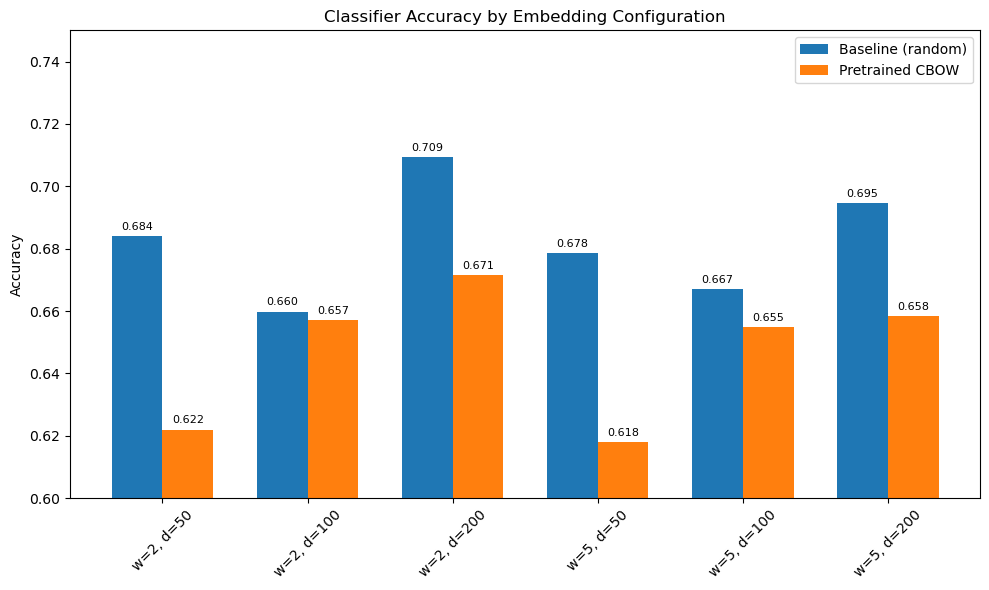

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Datos
configs = [
    "w=2, d=50", "w=2, d=100", "w=2, d=200",
    "w=5, d=50", "w=5, d=100", "w=5, d=200"
]
baseline_acc = [0.6839, 0.6598, 0.7093, 0.6785, 0.6670, 0.6946]
pretrained_acc = [0.6220, 0.6572, 0.6714, 0.6180, 0.6549, 0.6585]

x = np.arange(len(configs))
width = 0.35

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, baseline_acc, width, label='Baseline (random)')
bars2 = ax.bar(x + width/2, pretrained_acc, width, label='Pretrained CBOW')

# Etiquetas
ax.set_ylabel('Accuracy')
ax.set_title('Classifier Accuracy by Embedding Configuration')
ax.set_xticks(x)
ax.set_xticklabels(configs, rotation=45)
ax.set_ylim(0.6, 0.75)
ax.legend()

# Mostrar valores encima de las barras
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


##### Classifier Performance with Pretrained vs. Random Embeddings

The comparison between classifiers trained with pretrained CBOW embeddings and those using random embeddings (baseline) reveals that, across all configurations, the baseline consistently outperforms the pretrained models. This suggests that while the CBOW embeddings capture distributional semantics, they may not align optimally with the downstream classification task. The performance gap is particularly noticeable at window=2, emb_dim=200, where the baseline reaches 0.7093 accuracy compared to 0.6714 with pretrained embeddings. Interestingly, as embedding dimensions increase, both methods improve, but the pretrained gains lag behind. These results imply that task-specific tuning or fine-tuning might be necessary to leverage pretrained embeddings effectively in classification settings.

### 7. Comparative Experiment with a Larger Classifier Architecture

In this section, we evaluate whether a larger convolutional classifier benefits more from pre-trained embeddings.

We define a new function `build_classification_model2()` which uses deeper layers:
- Two Conv1D layers with **256 filters** (instead of 128)
- Same max pooling, global pooling, dropout, and dense output

The procedure is the same as before:
1. For each combination of `(context window, embedding dim)`:
   - Train a **baseline** classifier using randomly initialized embeddings
   - Train a **pretrained** classifier using frozen CBOW embeddings
   - Evaluate both models on the Reuters test set
   - Store training histories and test accuracies

Finally, we plot training and validation curves for both models to compare performance visually.

This experiment allows us to see if **larger architectures benefit more (or less)** from using pretrained embeddings.


In [49]:
# define a new function to build the classification model
def build_classification_model2(embeddings_matrix=None, emb_dim=100):
    model = Sequential()
    if embeddings_matrix is not None:
        emb_dim = embeddings_matrix.shape[1]
        model.add(Embedding(input_dim=VOCAB_SIZE,
                            output_dim=emb_dim,
                            weights=[embeddings_matrix],
                            trainable=False,
                            input_length=MAXLEN_CLS,
                            name='pretrained_emb'))
    else:
        # Random embeddings of same dim as baseline
        model.add(Embedding(input_dim=VOCAB_SIZE,
                            output_dim=emb_dim,
                            input_length=MAXLEN_CLS,
                            name='random_emb'))
    model.add(Conv1D(256, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(256, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



=== window=2, emb_dim=50 ===
Training baseline (random embeddings)...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Training with pretrained embeddings...
Baseline acc: 0.6741 — Pretrained acc: 0.6456


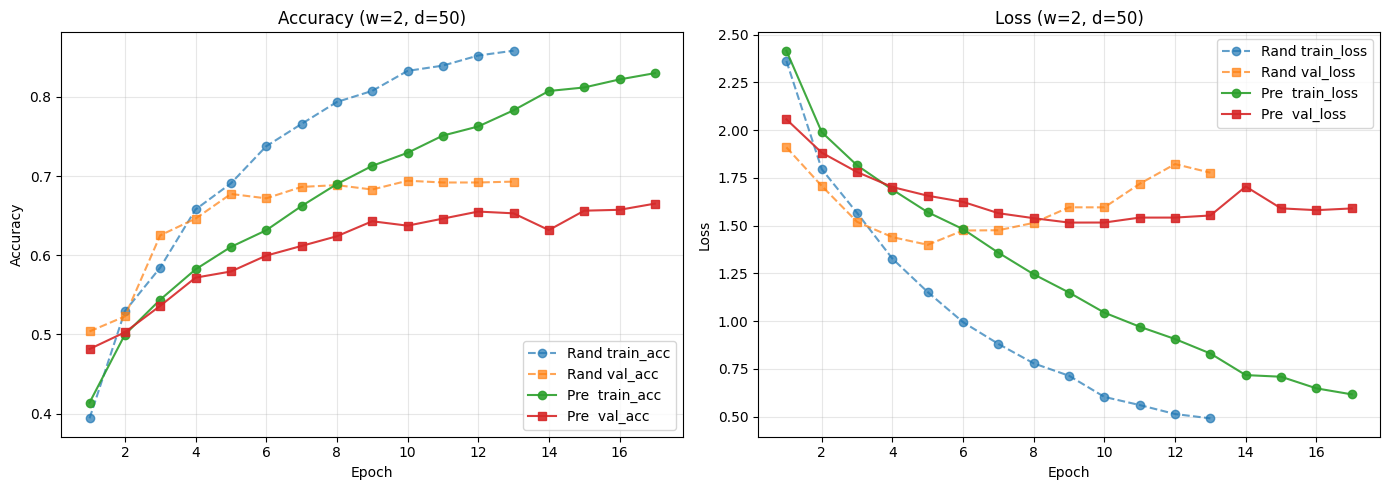


=== window=2, emb_dim=100 ===
Training baseline (random embeddings)...
Training with pretrained embeddings...
Baseline acc: 0.7035 — Pretrained acc: 0.6754


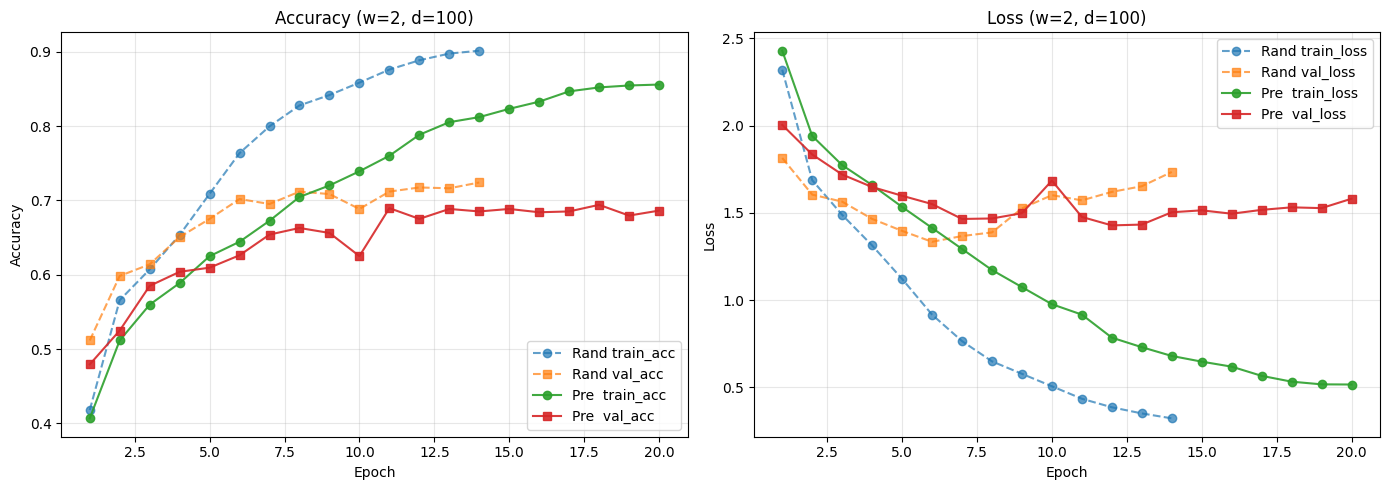


=== window=2, emb_dim=200 ===
Training baseline (random embeddings)...
Training with pretrained embeddings...
Baseline acc: 0.6928 — Pretrained acc: 0.6959


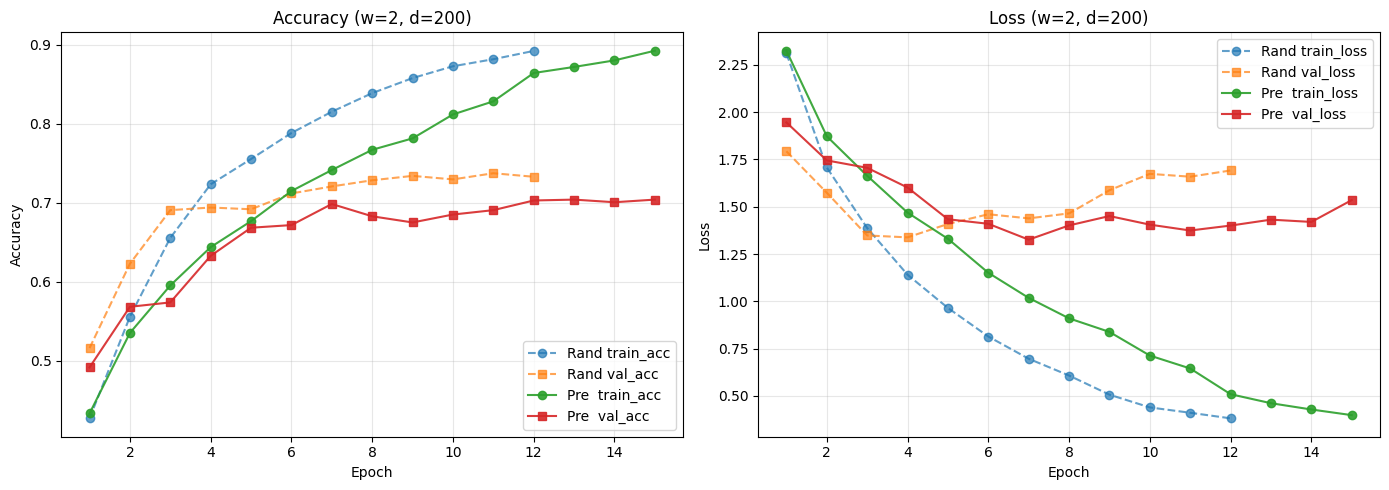


=== window=5, emb_dim=50 ===
Training baseline (random embeddings)...
Training with pretrained embeddings...
Baseline acc: 0.6451 — Pretrained acc: 0.6291


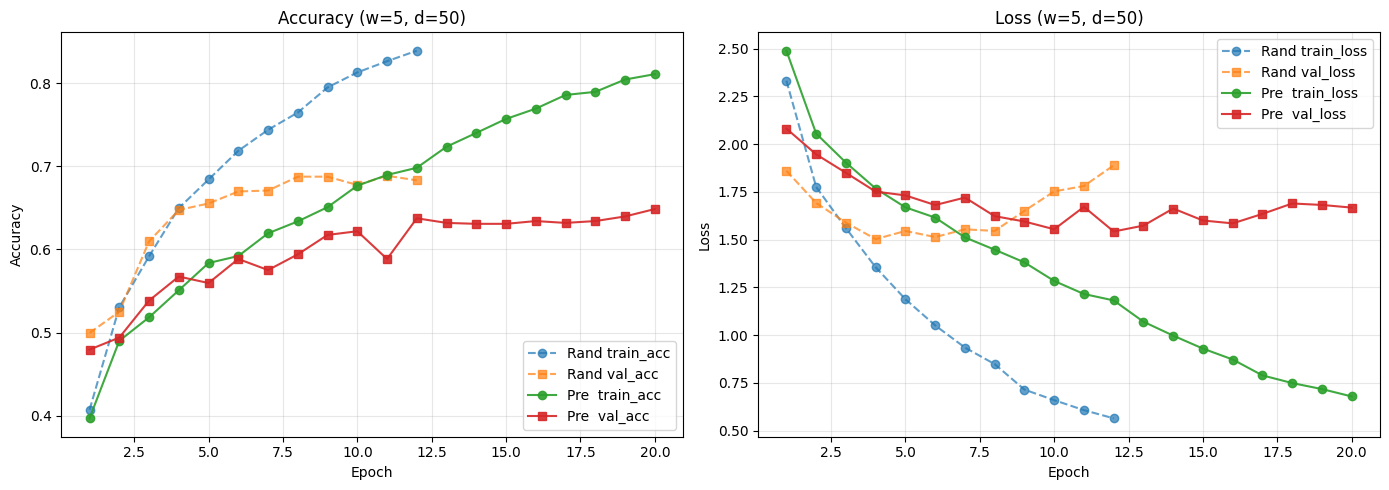


=== window=5, emb_dim=100 ===
Training baseline (random embeddings)...
Training with pretrained embeddings...
Baseline acc: 0.6736 — Pretrained acc: 0.6687


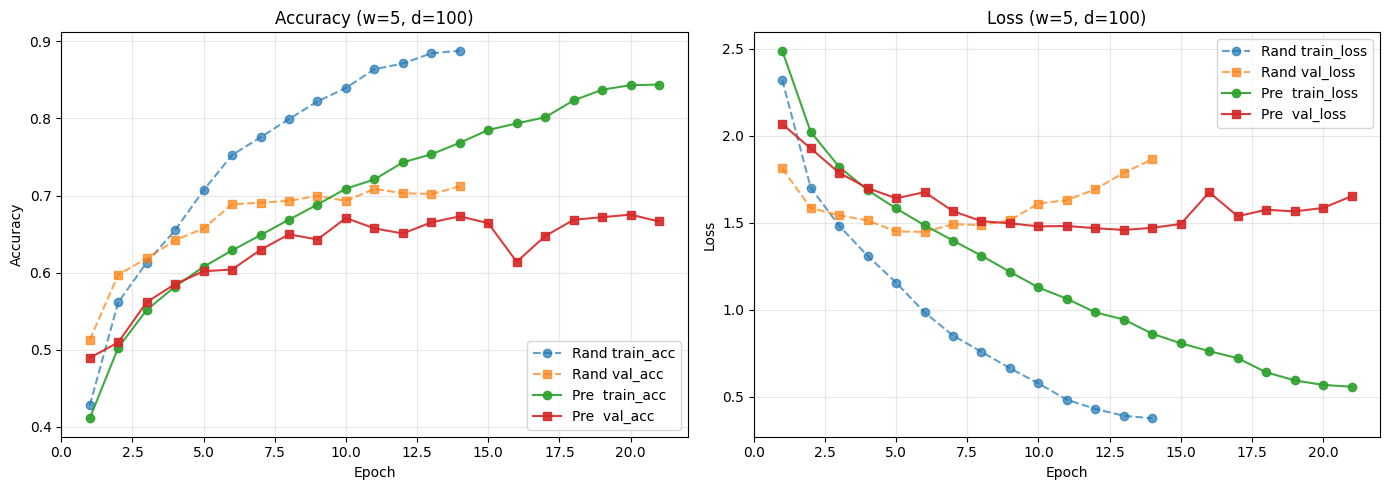


=== window=5, emb_dim=200 ===
Training baseline (random embeddings)...
Training with pretrained embeddings...
Baseline acc: 0.6986 — Pretrained acc: 0.6843


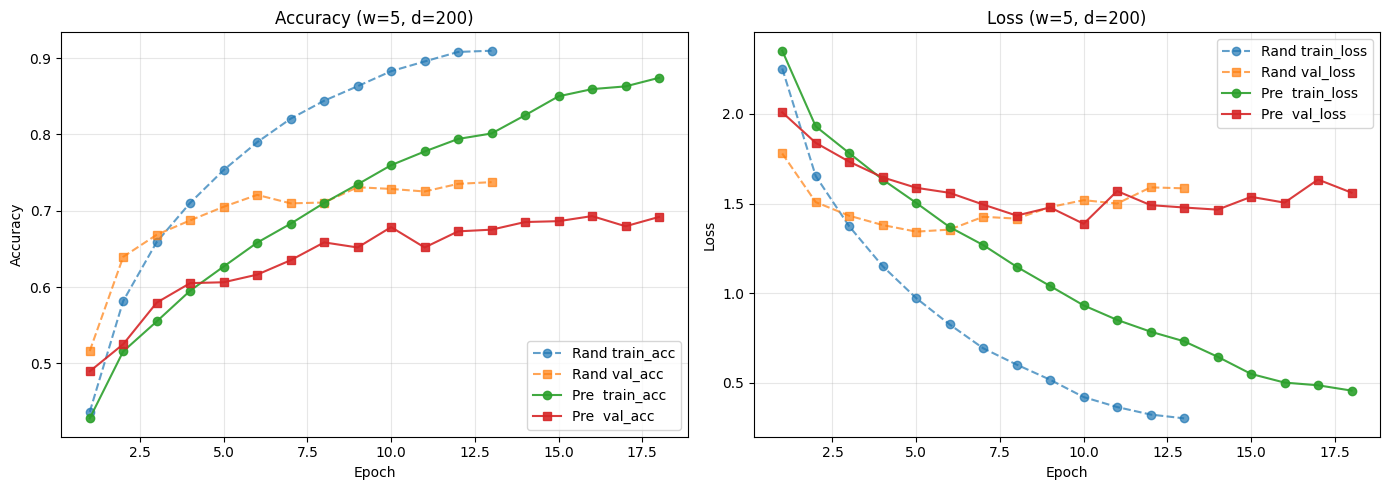

In [50]:
comparison_results2 = {}

for (window, dim), info in results.items():
    emb_matrix = info['embeddings']
    print(f"\n=== window={window}, emb_dim={dim} ===")

    # 3a) Baseline: random embeddings of size dim
    print("Training baseline (random embeddings)...")
    model_rand = build_classification_model2(embeddings_matrix=None, emb_dim=dim)
    hist_rand = model_rand.fit(
        x_train_r, y_train_r,
        validation_split=0.1,
        epochs=40,
        batch_size=128,
        callbacks=get_callbacks(),
        verbose=0
    )

    # 3b) With pretrained embeddings
    print("Training with pretrained embeddings...")
    model_pre = build_classification_model2(embeddings_matrix=emb_matrix)
    hist_pre = model_pre.fit(
        x_train_r, y_train_r,
        validation_split=0.1,
        epochs=40,
        batch_size=128,
        callbacks=get_callbacks(),
        verbose=0
    )

    # 3c) Evaluate on test set
    acc_rand = model_rand.evaluate(x_test_r, y_test_r, verbose=0)[1]
    acc_pre  = model_pre.evaluate(x_test_r, y_test_r, verbose=0)[1]
    print(f"Baseline acc: {acc_rand:.4f} — Pretrained acc: {acc_pre:.4f}")

    # 3d) Store histories & accuracies
    comparison_results2[(window, dim)] = {
        'hist_rand': hist_rand,
        'hist_pre': hist_pre,
        'acc_rand': acc_rand,
        'acc_pre': acc_pre
    }

    # 4) Plot comparison of training & validation curves
    plt.figure(figsize=(14,5))

    # --- Accuracy subplot ---
    plt.subplot(1, 2, 1)
    # Random baseline
    epochs_rand = range(1, len(hist_rand.history['accuracy']) + 1)
    plt.plot(epochs_rand, hist_rand.history['accuracy'],
            '--o', label='Rand train_acc', alpha=0.7)
    plt.plot(epochs_rand, hist_rand.history['val_accuracy'],
            '--s', label='Rand val_acc', alpha=0.7)

    # Pretrained
    epochs_pre = range(1, len(hist_pre.history['accuracy']) + 1)
    plt.plot(epochs_pre, hist_pre.history['accuracy'],
            '-o', label='Pre  train_acc', alpha=0.9)
    plt.plot(epochs_pre, hist_pre.history['val_accuracy'],
            '-s', label='Pre  val_acc', alpha=0.9)

    plt.title(f'Accuracy (w={window}, d={dim})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)

    # --- Loss subplot ---
    plt.subplot(1, 2, 2)
    # Random baseline
    plt.plot(epochs_rand, hist_rand.history['loss'],
            '--o', label='Rand train_loss', alpha=0.7)
    plt.plot(epochs_rand, hist_rand.history['val_loss'],
            '--s', label='Rand val_loss', alpha=0.7)

    # Pretrained
    plt.plot(epochs_pre, hist_pre.history['loss'],
            '-o', label='Pre  train_loss', alpha=0.9)
    plt.plot(epochs_pre, hist_pre.history['val_loss'],
            '-s', label='Pre  val_loss', alpha=0.9)

    plt.title(f'Loss (w={window}, d={dim})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()



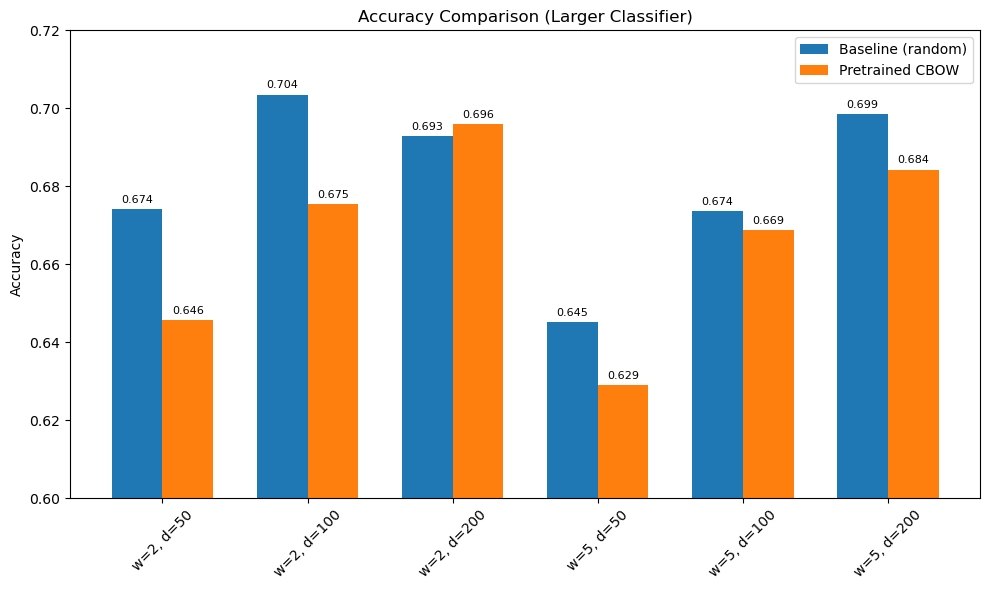

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Datos del experimento con red más grande
configs = [
    "w=2, d=50", "w=2, d=100", "w=2, d=200",
    "w=5, d=50", "w=5, d=100", "w=5, d=200"
]
baseline_acc = [0.6741, 0.7035, 0.6928, 0.6451, 0.6736, 0.6986]
pretrained_acc = [0.6456, 0.6754, 0.6959, 0.6291, 0.6687, 0.6843]

x = np.arange(len(configs))
width = 0.35

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, baseline_acc, width, label='Baseline (random)')
bars2 = ax.bar(x + width/2, pretrained_acc, width, label='Pretrained CBOW')

# Etiquetas
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison (Larger Classifier)')
ax.set_xticks(x)
ax.set_xticklabels(configs, rotation=45)
ax.set_ylim(0.60, 0.72)
ax.legend()

# Mostrar valores encima de las barras
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In the comparative experiment using a larger classifier architecture, the overall accuracy improved for both baseline and pretrained embeddings across most configurations. Interestingly, while the baseline (random embeddings) still outperformed the pretrained CBOW embeddings in most cases, the gap between them narrowed compared to the simpler classifier. For instance, with window=2 and dim=200, the pretrained embeddings slightly surpassed the baseline (0.6959 vs. 0.6928), indicating that richer representations can become more beneficial as model capacity increases. Nonetheless, in lower-dimensional settings, the pretrained embeddings remained less effective than randomly initialized ones. This suggests that while pretrained embeddings encode useful distributional semantics, their benefit might depend on both model complexity and embedding dimensionality.

### 8. Finetuning Experiment: Comparing Frozen vs. Trainable Embeddings

In this experiment, we extend our classifier comparison by introducing a third setting:

1. **Baseline**: Randomly initialized embeddings (trainable)
2. **Pretrained Frozen**: Use CBOW-trained embeddings with `trainable=False`
3. **Pretrained Finetuned**: Use CBOW embeddings but allow training to continue (`trainable=True`)

We define a new function `build_classification_model3()` that allows control over whether to fine-tune the embedding layer.

For each `(context window, embedding dim)`:
- We train the classifier under the 3 settings above.
- We evaluate all 3 models on the Reuters test set.
- Validation accuracy/loss curves are plotted to observe training behavior and generalization.

This experiment helps to answer:
- Is it better to freeze or fine-tune the CBOW embeddings?
- Are pretrained embeddings always beneficial, or only under certain dimensions or windows?



=== window=2, emb_dim=50 ===
-- Baseline --


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Baseline Test Accuracy: 0.6736
-- Pretrained Frozen --
Pretrained Frozen Test Accuracy: 0.6647
-- Pretrained Finetuned --
Pretrained Finetuned Test Accuracy: 0.7106


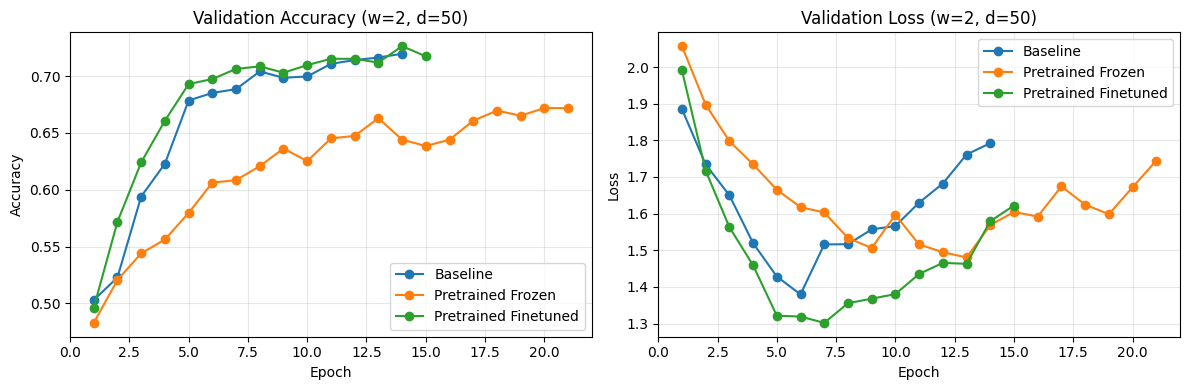


=== window=2, emb_dim=100 ===
-- Baseline --
Baseline Test Accuracy: 0.6692
-- Pretrained Frozen --
Pretrained Frozen Test Accuracy: 0.6794
-- Pretrained Finetuned --
Pretrained Finetuned Test Accuracy: 0.7195


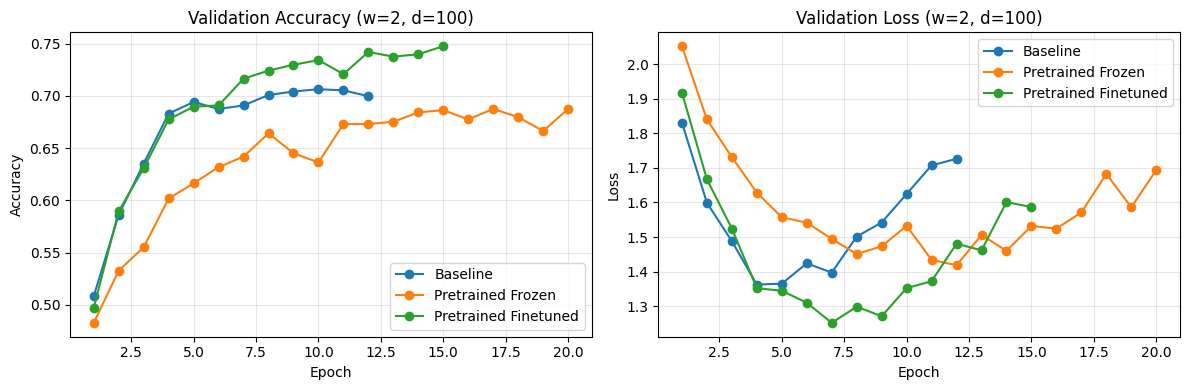


=== window=2, emb_dim=200 ===
-- Baseline --
Baseline Test Accuracy: 0.7204
-- Pretrained Frozen --
Pretrained Frozen Test Accuracy: 0.6857
-- Pretrained Finetuned --
Pretrained Finetuned Test Accuracy: 0.7520


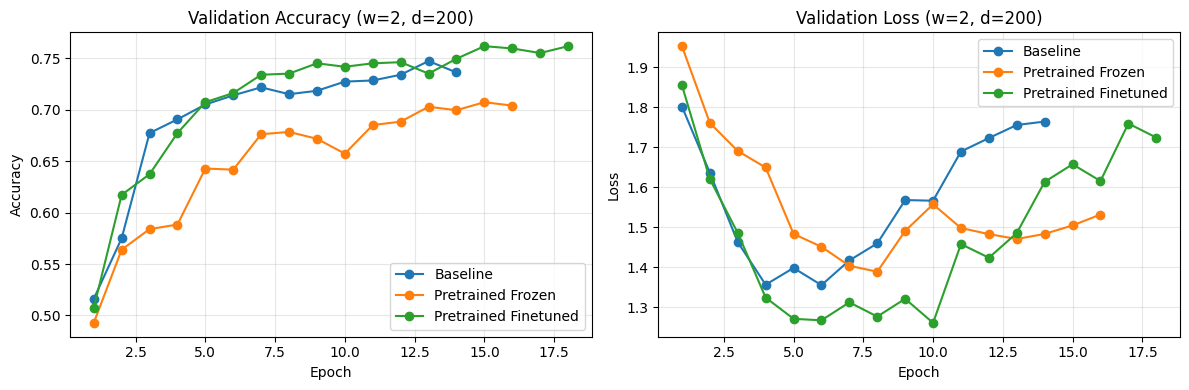


=== window=5, emb_dim=50 ===
-- Baseline --
Baseline Test Accuracy: 0.6376
-- Pretrained Frozen --
Pretrained Frozen Test Accuracy: 0.6171
-- Pretrained Finetuned --
Pretrained Finetuned Test Accuracy: 0.6750


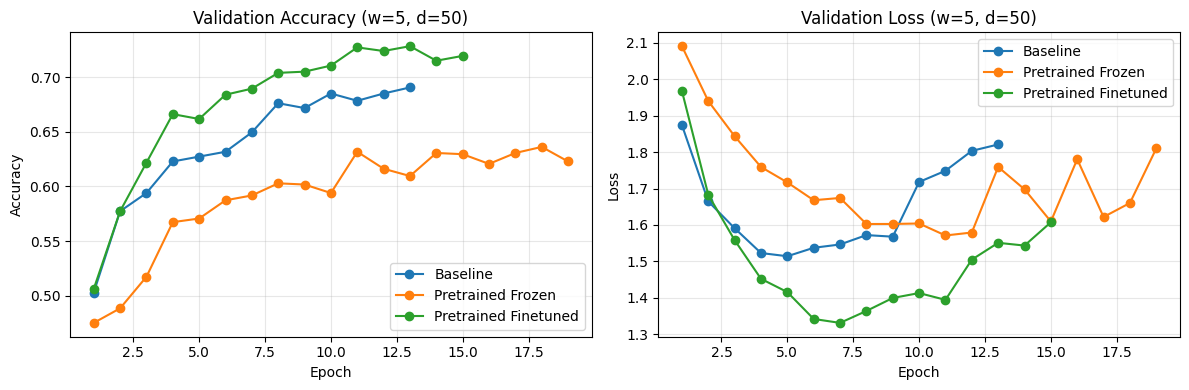


=== window=5, emb_dim=100 ===
-- Baseline --
Baseline Test Accuracy: 0.6888
-- Pretrained Frozen --
Pretrained Frozen Test Accuracy: 0.6478
-- Pretrained Finetuned --
Pretrained Finetuned Test Accuracy: 0.7182


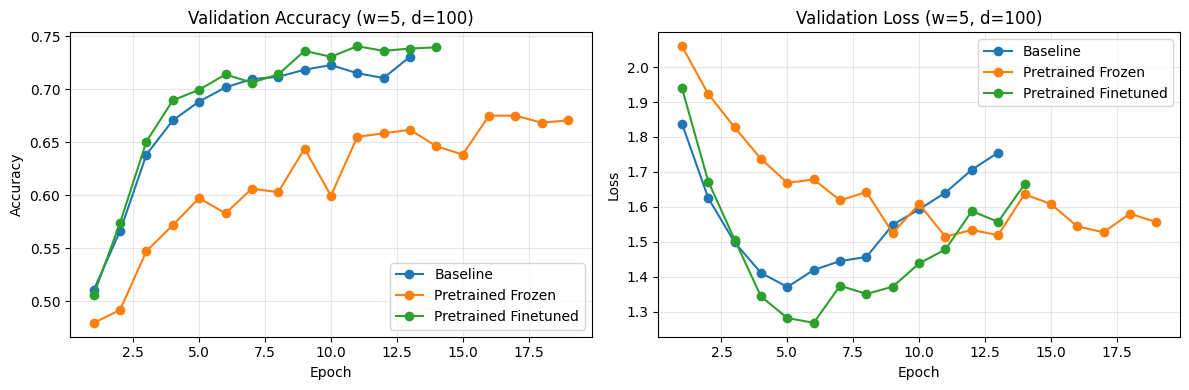


=== window=5, emb_dim=200 ===
-- Baseline --
Baseline Test Accuracy: 0.6772
-- Pretrained Frozen --
Pretrained Frozen Test Accuracy: 0.6821
-- Pretrained Finetuned --
Pretrained Finetuned Test Accuracy: 0.7128


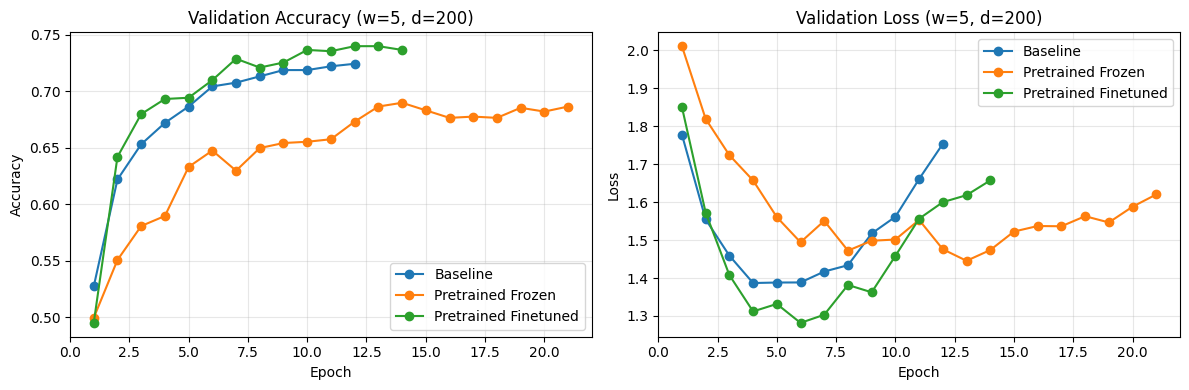

In [13]:
def build_classification_model3(embeddings_matrix=None, emb_dim=100, finetune=False):
    """
    If embeddings_matrix is None → random embeddings of size emb_dim;
    else → load embeddings_matrix (shape [vocab, emb_dim]) into the layer,
    with trainable=finetune.
    """
    model = Sequential()
    if embeddings_matrix is not None:
        emb_dim = embeddings_matrix.shape[1]
        model.add(Embedding(input_dim=VOCAB_SIZE,
                            output_dim=emb_dim,
                            weights=[embeddings_matrix],
                            trainable=finetune,
                            input_length=MAXLEN_CLS,
                            name='pretrained_emb'))
    else:
        model.add(Embedding(input_dim=VOCAB_SIZE,
                            output_dim=emb_dim,
                            trainable=True,
                            input_length=MAXLEN_CLS,
                            name='random_emb'))
    model.add(Conv1D(256, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(256, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 4) Train & compare Baseline / Frozen / Finetuned for each (window, dim)
comparison_results3 = {}  # aquí almacenamos cada historia y accuracy

for window in context_windows:
    for dim in embedding_dims:
        print(f"\n=== window={window}, emb_dim={dim} ===")
        # Load pretrained embeddings from disk
        emb_matrix = np.load(f'embeddings_w{window}_d{dim}.npy')

        # Train the three variants and collect their histories
        histories = {}
        for label, emb_arg, finetune in [
            ("Baseline",            None,       False),
            ("Pretrained Frozen",   emb_matrix, False),
            ("Pretrained Finetuned",emb_matrix, True),
        ]:
            print(f"-- {label} --")
            model = build_classification_model3(
                embeddings_matrix=emb_arg,
                emb_dim=dim,
                finetune=finetune
            )
            history = model.fit(
                x_train_r, y_train_r,
                validation_split=0.1,
                epochs=40,
                batch_size=128,
                callbacks=get_callbacks(),
                verbose=0
            )
            acc = model.evaluate(x_test_r, y_test_r, verbose=0)[1]
            print(f"{label} Test Accuracy: {acc:.4f}")

            histories[label] = history
            comparison_results3[(window, dim, label)] = {
                'history': history,
                'accuracy': acc
            }

        # 5) Plot only the validation curves, allowing different epoch lengths
        plt.figure(figsize=(12,4))

        # Validation Accuracy
        plt.subplot(1, 2, 1)
        for label, hist in histories.items():
            epochs_val = range(1, len(hist.history['val_accuracy']) + 1)
            plt.plot(epochs_val, hist.history['val_accuracy'], '-o', label=label)
        plt.title(f'Validation Accuracy (w={window}, d={dim})')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(alpha=0.3)

        # Validation Loss
        plt.subplot(1, 2, 2)
        for label, hist in histories.items():
            epochs_val = range(1, len(hist.history['val_loss']) + 1)
            plt.plot(epochs_val, hist.history['val_loss'], '-o', label=label)
        plt.title(f'Validation Loss (w={window}, d={dim})')
        plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

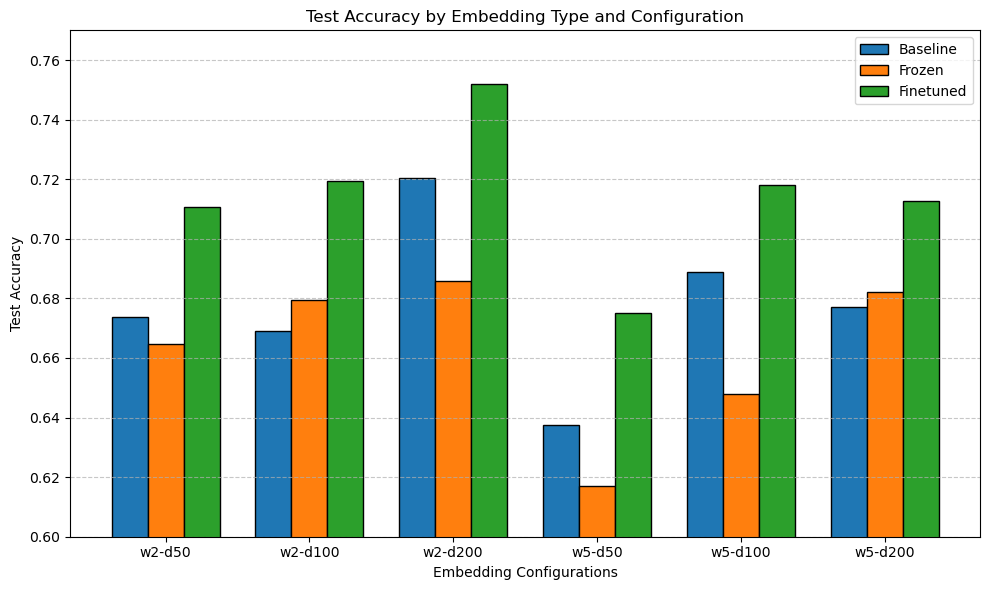

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# etiquetas para cada configuración
configs = [
    "w2-d50", "w2-d100", "w2-d200",
    "w5-d50", "w5-d100", "w5-d200"
]

# valores de precisión (Baseline, Frozen, Finetuned)
baseline_acc = [0.6736, 0.6692, 0.7204, 0.6376, 0.6888, 0.6772]
frozen_acc =  [0.6647, 0.6794, 0.6857, 0.6171, 0.6478, 0.6821]
finetuned_acc = [0.7106, 0.7195, 0.7520, 0.6750, 0.7182, 0.7128]

x = np.arange(len(configs))  # posiciones en eje X
width = 0.25  # ancho de cada barra

plt.figure(figsize=(10, 6))
plt.bar(x - width, baseline_acc, width, label='Baseline', edgecolor='black')
plt.bar(x, frozen_acc, width, label='Frozen', edgecolor='black')
plt.bar(x + width, finetuned_acc, width, label='Finetuned', edgecolor='black')

plt.xlabel('Embedding Configurations')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy by Embedding Type and Configuration')
plt.xticks(x, configs)
plt.ylim(0.6, 0.77)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


The fine-tuning experiment reveals a clear advantage when allowing pretrained embeddings to be updated during training. In all configurations, finetuned embeddings consistently outperform both the frozen embeddings and the random baseline. For example, with window=2 and dim=200, finetuned embeddings achieved a test accuracy of 0.7520, notably higher than the baseline (0.7204) and frozen version (0.6857). This trend is consistent across all window sizes and embedding dimensions, suggesting that while static pretrained embeddings may not always surpass random initialization, giving the model the flexibility to adapt them during training significantly boosts performance. This demonstrates the importance of contextual adaptation in downstream tasks.

# 9. General Conclusions
Across all experiments, we observe consistent patterns regarding the use of pretrained embeddings. In Experiment 6 (simple classifier), randomly initialized embeddings slightly outperform pretrained ones, likely due to the classifier's limited capacity to leverage the semantic information in static embeddings. Experiment 7 (larger classifier) shows a narrower performance gap, and in some cases, pretrained embeddings outperform the baseline, suggesting that a deeper architecture can better exploit pretrained knowledge. Most notably, Experiment 8 (fine-tuning) demonstrates a clear benefit of making embeddings trainable: fine-tuned embeddings outperform both frozen and randomly initialized embeddings in nearly all configurations. These findings highlight the importance of model capacity and embedding flexibility—while pretrained embeddings may not always help with small models, their full potential is unlocked when combined with fine-tuning and larger classifiers.



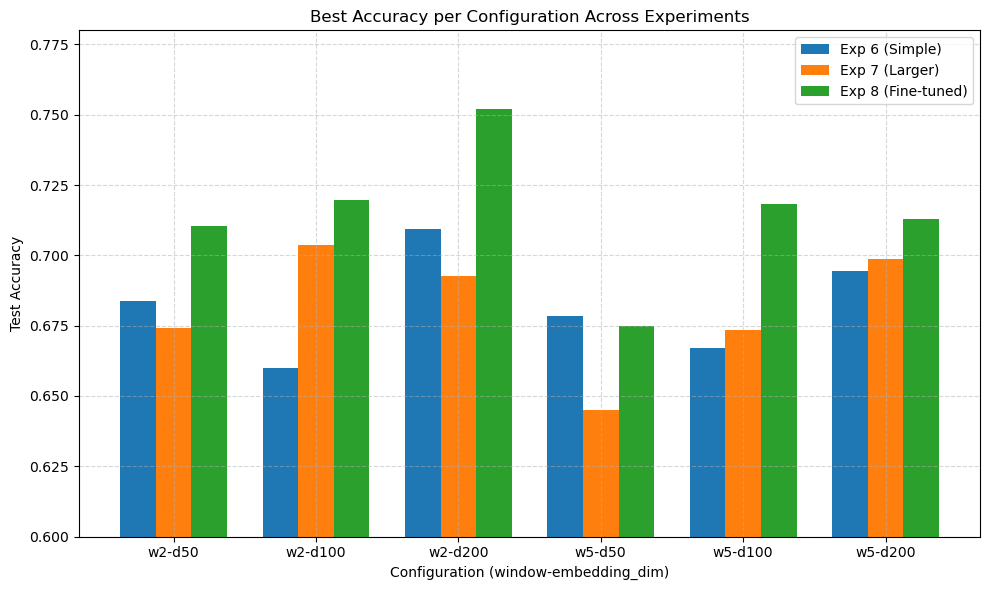

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Datos: mejores resultados por configuración (solo finetuned en exp 8, baseline en 6 y 7)
configs = [
    "w2-d50", "w2-d100", "w2-d200",
    "w5-d50", "w5-d100", "w5-d200"
]

# Accuracy por configuración y experimento
# Orden: [exp6, exp7, exp8_finetuned]
accuracies = {
    "w2-d50":   [0.6839, 0.6741, 0.7106],
    "w2-d100":  [0.6598, 0.7035, 0.7195],
    "w2-d200":  [0.7093, 0.6928, 0.7520],
    "w5-d50":   [0.6785, 0.6451, 0.6750],
    "w5-d100":  [0.6670, 0.6736, 0.7182],
    "w5-d200":  [0.6946, 0.6986, 0.7128],
}

labels = list(accuracies.keys())
x = np.arange(len(labels))
exp6_vals = [accuracies[k][0] for k in labels]
exp7_vals = [accuracies[k][1] for k in labels]
exp8_vals = [accuracies[k][2] for k in labels]

width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, exp6_vals, width, label='Exp 6 (Simple)')
plt.bar(x,         exp7_vals, width, label='Exp 7 (Larger)')
plt.bar(x + width, exp8_vals, width, label='Exp 8 (Fine-tuned)')

plt.ylabel('Test Accuracy')
plt.xlabel('Configuration (window-embedding_dim)')
plt.title('Best Accuracy per Configuration Across Experiments')
plt.xticks(x, labels)
plt.ylim(0.60, 0.78)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


de aqui pabajo yo lo borraba

In [ ]:
#otra prueba unificando un poco de todo
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

(x_train_r, y_train_r), (x_test_r, y_test_r) = reuters.load_data(num_words=vocab_size)

# preprocess data
maxlen_cls = 256
x_train_r = pad_sequences(x_train_r, maxlen=maxlen_cls)
x_test_r = pad_sequences(x_test_r, maxlen=maxlen_cls)
y_train_r = to_categorical(y_train_r)
y_test_r = to_categorical(y_test_r)
num_classes = y_train_r.shape[1]

# define model builder functions
def build_model(use_pretrained=False, finetune=False):
    model = Sequential()
    if use_pretrained:
        model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            weights=[embeddings], trainable=finetune, input_length=maxlen_cls))
    else:
        model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            input_length=maxlen_cls))

    model.add(Conv1D(256, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(256, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# train models
# Baseline (random embeddings)
model_base = build_model(use_pretrained=False)
history_base = model_base.fit(x_train_r, y_train_r, validation_split=0.1, epochs=20, batch_size=128, verbose=2)

# Pretrained embeddings (frozen)
model_pre = build_model(use_pretrained=True, finetune=False)
history_pre = model_pre.fit(x_train_r, y_train_r, validation_split=0.1, epochs=20, batch_size=128, verbose=2)

# Pretrained embeddings (fine-tuned)
model_pre_finetuned = build_model(use_pretrained=True, finetune=True)
history_pre_finetuned = model_pre_finetuned.fit(x_train_r, y_train_r, validation_split=0.1, epochs=20, batch_size=128, verbose=2)

# Evaluate models
baseline_accuracy = model_base.evaluate(x_test_r, y_test_r, verbose=0)[1]
pretrained_accuracy = model_pre.evaluate(x_test_r, y_test_r, verbose=0)[1]
pretrained_finetuned_accuracy = model_pre_finetuned.evaluate(x_test_r, y_test_r, verbose=0)[1]

print(f'Baseline Test Accuracy: {baseline_accuracy:.4f}')
print(f'Pretrained (Frozen) Test Accuracy: {pretrained_accuracy:.4f}')
print(f'Pretrained (Fine-tuned) Test Accuracy: {pretrained_finetuned_accuracy:.4f}')


Epoch 1/20
64/64 - 5s - 81ms/step - accuracy: 0.4356 - loss: 2.3438 - val_accuracy: 0.5117 - val_loss: 1.8258
Epoch 2/20
64/64 - 4s - 58ms/step - accuracy: 0.5564 - loss: 1.7139 - val_accuracy: 0.6051 - val_loss: 1.6140
Epoch 3/20
64/64 - 4s - 57ms/step - accuracy: 0.6117 - loss: 1.4914 - val_accuracy: 0.6374 - val_loss: 1.5127
Epoch 4/20
64/64 - 4s - 58ms/step - accuracy: 0.6740 - loss: 1.3016 - val_accuracy: 0.6752 - val_loss: 1.3698
Epoch 5/20
64/64 - 4s - 60ms/step - accuracy: 0.7225 - loss: 1.1144 - val_accuracy: 0.6785 - val_loss: 1.3973
Epoch 6/20
64/64 - 4s - 55ms/step - accuracy: 0.7512 - loss: 0.9739 - val_accuracy: 0.6897 - val_loss: 1.4355
Epoch 7/20
64/64 - 4s - 55ms/step - accuracy: 0.7857 - loss: 0.8386 - val_accuracy: 0.6997 - val_loss: 1.4127
Epoch 8/20
64/64 - 4s - 59ms/step - accuracy: 0.8056 - loss: 0.7494 - val_accuracy: 0.7086 - val_loss: 1.4449
Epoch 9/20
64/64 - 4s - 59ms/step - accuracy: 0.8214 - loss: 0.6725 - val_accuracy: 0.7008 - val_loss: 1.4591
Epoch 10/2

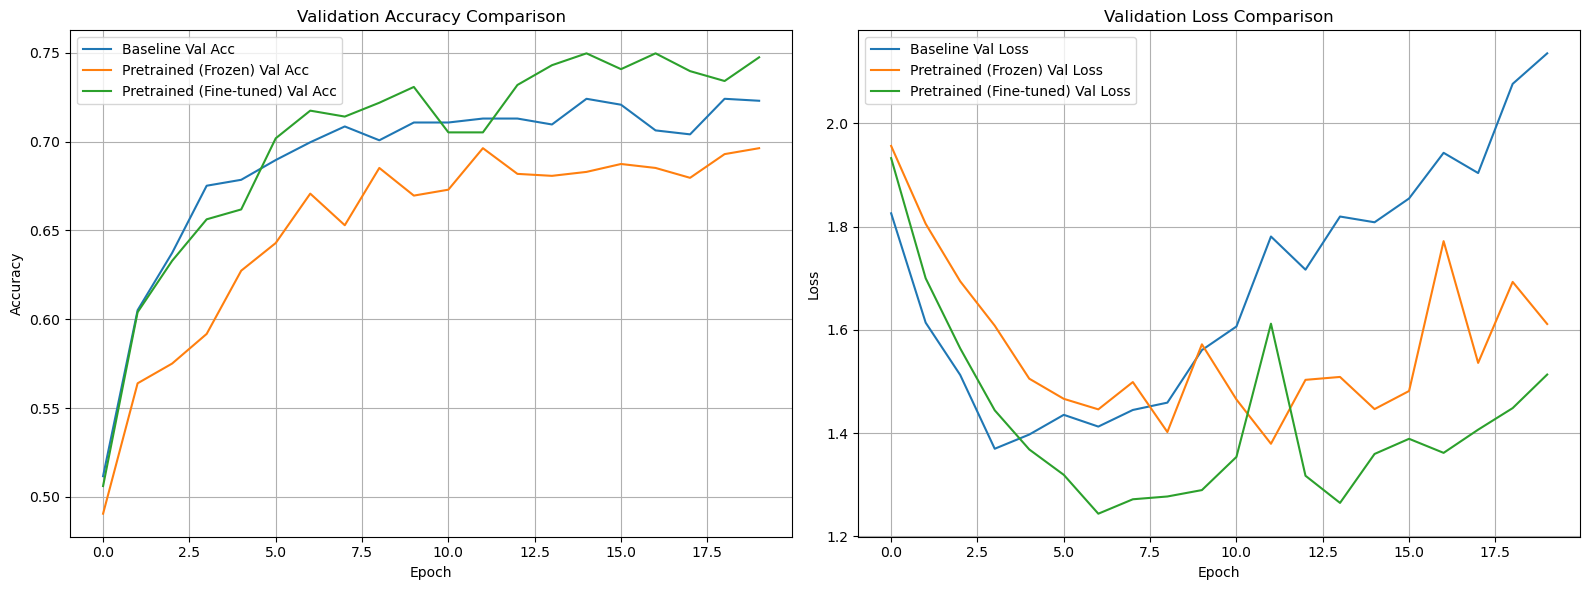

Models saved successfully!


In [ ]:
# plot training history
plt.figure(figsize=(16, 6))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(history_base.history['val_accuracy'], label='Baseline Val Acc')
plt.plot(history_pre.history['val_accuracy'], label='Pretrained (Frozen) Val Acc')
plt.plot(history_pre_finetuned.history['val_accuracy'], label='Pretrained (Fine-tuned) Val Acc')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# loss
plt.subplot(1, 2, 2)
plt.plot(history_base.history['val_loss'], label='Baseline Val Loss')
plt.plot(history_pre.history['val_loss'], label='Pretrained (Frozen) Val Loss')
plt.plot(history_pre_finetuned.history['val_loss'], label='Pretrained (Fine-tuned) Val Loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# save models
model_base.save('model_baseline.h5')
model_pre.save('model_pretrained_frozen.h5')
model_pre_finetuned.save('model_pretrained_finetuned.h5')

print("Models saved successfully!")

# 10. Discussion and Next Steps

- Analyze results: impact of context window, embedding dim, pretrained vs scratch
- Explore larger corpora or external embeddings (fastText, Gensim)
- Document findings and prepare report (max 3 pages)
- Prepare defense slides